In [1]:
import grid2op
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.Parameters import Parameters
from superposition_theorem import *
param = Parameters()
param.ENV_DC = True
param.MAX_LINE_STATUS_CHANGED = 99999
param.MAX_SUB_CHANGED = 99999
backend=LightSimBackend()
env = grid2op.make("l2rpn_case14_sandbox", param=param,backend=backend)


/Users/antoinemarot/dev/LIPS/venv_LIPS/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
/Users/antoinemarot/dev/LIPS/venv_LIPS/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
/Users/antoinemarot/dev/LIPS/venv_LIPS/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")
/Users/antoinemarot/dev/LIPS/venv_LIPS/lib/pyth

In [2]:
import sys
paths=[i for i in sys.path]


for path in paths:
    sys.path.append(path)

# compute the A matrix that defines the delta

$$\delta_{i,j} = \frac{F_j^{i} - F_j}{F_i}$$

with:
- $\delta_{i,j}$ : "le coefficient de report"
- $F_k$: the active flow on line `k`
- $F_j^{i}$: the flow on line j if the line i is disconnected

We are interested, given all the $\delta_{i,j}$ to compute the $\delta_{\{i,j,k, ...\}, m}$ which are the flows on line `m` when the lines $\{i,j,k, ...\}$ are disconnected

In [3]:
_ = env.reset()
#with env.copy() as tmp_env_init:
init_obs, *_ = env.simulate(env.action_space())
F = 1. * init_obs.p_or

In [4]:
init_obs

In [5]:
all_flows = np.zeros((env.n_line, env.n_line))
for l_id in range(env.n_line):
    #with env.copy() as tmp_env:
    obs, *_ = env.simulate(env.action_space({"set_line_status": [(l_id, -1)]}))
    all_flows[l_id, :] = obs.p_or

In [6]:
A = (all_flows - F) / F.reshape(-1, 1)

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_12998/3487405670.py:1: RuntimeWarning: divide by zero encountered in true_divide
  A = (all_flows - F) / F.reshape(-1, 1)
/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_12998/3487405670.py:1: RuntimeWarning: invalid value encountered in true_divide
  A = (all_flows - F) / F.reshape(-1, 1)


In [7]:
F

array([ 38.58359  ,  37.61641  ,  22.565678 ,  41.696144 ,  35.121765 ,
        16.86568  , -29.562853 ,   6.4211507,   7.0682087,  16.285961 ,
         5.7788496,   9.545831 ,  -3.0211506,   1.5682089,   5.2541695,
        27.484486 ,  16.040195 ,  36.275322 ,   0.       , -27.484486 ],
      dtype=float32)

In [8]:
A[3][3]

-1.0

In [9]:
init_obs.p_or[2] + A[1, 2] * init_obs.p_or[1]

28.917064666748047

In [10]:
all_flows[1, 2]

28.917064666748047

In [11]:
all_flows[1]

array([ 76.19999695,   0.        ,  28.91706467,  54.98823929,
        53.09469223,  23.21706772, -11.00502491,   5.76739502,
         6.9721899 ,  15.95008183,   6.43260527,   9.9777298 ,
        -2.36739492,   1.47218966,   4.82227087,  28.17004204,
        16.44029236,  35.18966675,   0.        , -28.17004204])

In [12]:
env.name_line

array(['0_1_0', '0_4_1', '1_2_2', '1_3_3', '1_4_4', '2_3_5', '3_4_6',
       '5_10_7', '5_11_8', '5_12_9', '8_9_10', '8_13_11', '9_10_12',
       '11_12_13', '12_13_14', '3_6_15', '3_8_16', '4_5_17', '6_7_18',
       '6_8_19'], dtype='<U8')

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_12998/1957509643.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


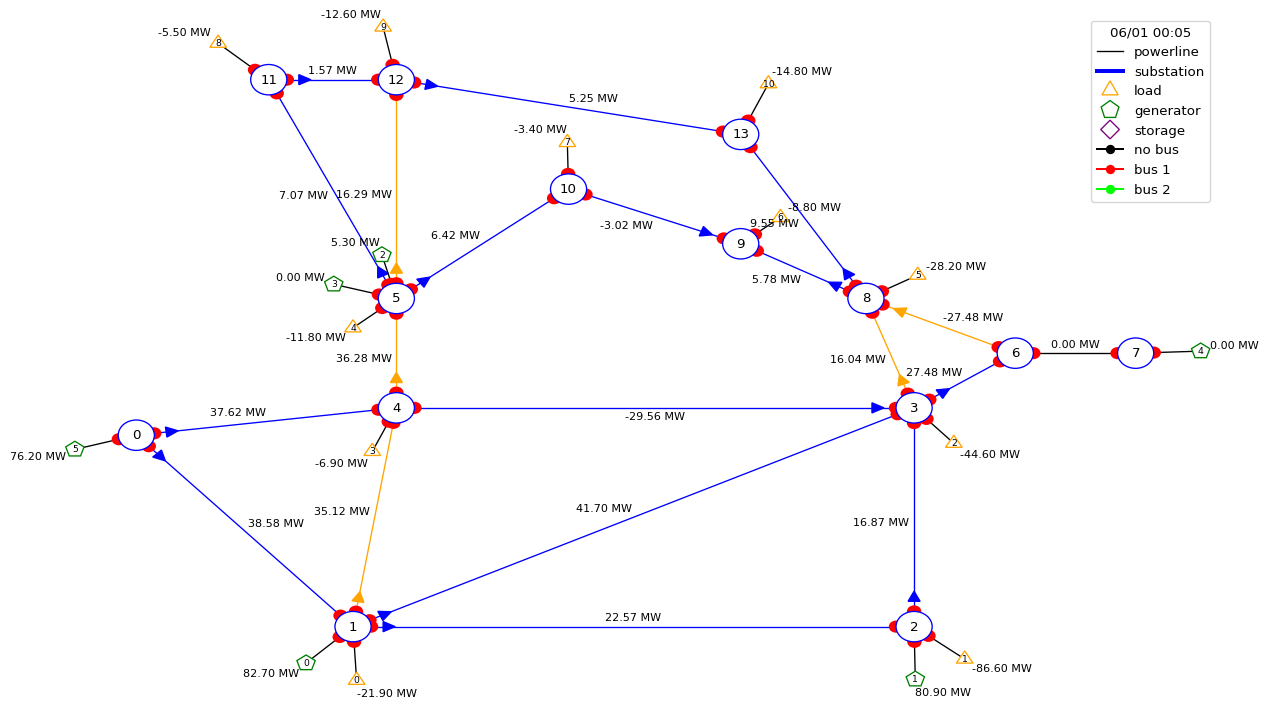

In [13]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(init_obs,line_info="p")
fig.show()


In [14]:
init_obs.p_or

array([ 38.58359  ,  37.61641  ,  22.565678 ,  41.696144 ,  35.121765 ,
        16.86568  , -29.562853 ,   6.4211507,   7.0682087,  16.285961 ,
         5.7788496,   9.545831 ,  -3.0211506,   1.5682089,   5.2541695,
        27.484486 ,  16.040195 ,  36.275322 ,   0.       , -27.484486 ],
      dtype=float32)

In [15]:
id_l1=3
id_l2=7
id_l3=0
#with env.copy() as tmp_env:
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))

In [16]:
def get_reconnection_LODF(ils_connect,env):
    
    n_lines=env.n_line
    n_lines_connect=len(ils_connect)
    reconnection_LODF=np.zeros((n_lines,n_lines_connect))
    
    
    obs_all_disconnected, *_ = env.simulate(env.action_space({"set_line_status": [(ilj, -1) for ilj in ils_connect]}))
    p_obs_all_disconnected=obs_all_disconnected.p_or
    
    for i,il in enumerate(ils_connect):
        print("line "+str(il)+" is connected")
        obs_connect_l, *_ = env.simulate(env.action_space({"set_line_status": [(ilj, -1) for ilj in ils_connect if ilj!=il]}))
        p_obs_connect_l=obs_connect_l.p_or
        reconnection_LODF[:,i]=(p_obs_all_disconnected-p_obs_connect_l)/p_obs_connect_l[il]
    
    return reconnection_LODF
    
    

In [17]:
def get_delta_theta_line(obs,id_line):
    theta_or=obs.theta_or
    theta_ex=obs.theta_ex

    sub_l_ex=obs.line_ex_to_subid[id_line]
    sub_l_or=obs.line_or_to_subid[id_line]
    lines_sub_or_l=list(obs.get_obj_connect_to(substation_id=sub_l_or)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_l_or)['lines_ex_id'])
    lines_sub_ex_l=list(obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_ex_id'])

    #print(id_line)
    #print(lines_sub_or_l)
    #print(lines_sub_ex_l)
    theta_or_l=0.
    #for ids of thetas, cf previous section where we identified those
    thetas_or_l=np.append(theta_or[obs.get_obj_connect_to(substation_id=sub_l_or)['lines_or_id']],
                          theta_ex[obs.get_obj_connect_to(substation_id=sub_l_or)['lines_ex_id']])
    thetas_or_l=thetas_or_l[thetas_or_l!=0]

    if len(thetas_or_l)!=0:
        if (np.sum(np.abs(thetas_or_l))!=0):
            thetas_or_l=thetas_or_l[thetas_or_l!=0]
        theta_or_l=np.median(thetas_or_l)
    
    theta_ex_l=0.
    thetas_ex_l=np.append(theta_or[obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_or_id']],
                    theta_ex[obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_ex_id']])
    thetas_ex_l=thetas_ex_l[thetas_ex_l!=0]

    if len(thetas_ex_l)!=0:
        if (np.sum(np.abs(theta_ex_l))!=0):
            theta_ex_l=theta_ex_l[theta_ex_l!=0]
        theta_ex_l=np.median(thetas_ex_l)
    delta_theta_l=theta_or_l-theta_ex_l
    #delta_theta_l2=theta_or[8]-theta_ex[12]
    #print(delta_theta_l)
    
    return delta_theta_l/360*2*3.14159


## compute virtual flows for disconnections without using LODF


### compute Equivalent Resistance Matrix to see if we can use it to deduce virtual flows

In [18]:
YBus=env.backend._grid.get_dcYbus().todense()

In [19]:
pinv_Bbus=np.linalg.pinv(YBus)
n_nodes=pinv_Bbus.shape[0]
R_eq=np.array([[pinv_Bbus[i,i]+pinv_Bbus[j,j]-2*pinv_Bbus[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

### Scenario 1: disconnecting 1 line and assessing virtual flow - easy scenario

In [20]:
#lines to disconnect
[id_l1,id_l2,id_l3]


[3, 7, 0]

In [21]:
# virtual flows when disconnecting the 3 lines
#id_l1=2
#id_l2=4
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end=get_Virtual_Flows_NK(por_init,A,[id_l1,id_l2])#[id_l1,id_l2,id_l3])
p_end

[42.17226227  7.42411841]


(array([ 2.7362656e+01,  4.8837345e+01,  3.4829128e+01, -9.7242046e-09,
         5.3333527e+01,  2.9129133e+01, -6.1824879e+01,  1.0504630e-07,
         7.8667388e+00,  1.9079252e+01,  1.2200000e+01,  5.9540105e+00,
         3.4000001e+00,  2.3667386e+00,  8.8459892e+00,  2.9271120e+01,
         1.7082891e+01,  3.3445988e+01,  0.0000000e+00, -2.9271120e+01],
       dtype=float32),
 array([42.17226227,  7.42411841]))

In [22]:
init_obs.p_or[[id_l1,id_l2]]#,id_l3]]

array([41.696144 ,  6.4211507], dtype=float32)

In [23]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

In [24]:
obs_disconnect_l1.p_or[id_l2]

7.412795

In [25]:
obs_disconnect_l2.p_or[id_l1]

42.10794

In [26]:
#por_virtual=por_init
#for i in range(len(ilds)):
# por_virtual+=A[ilds[i]]*pls_virtual[i]


In [27]:
p_virt_sum=42.17226227+7.42411841
coeff = [1,-p_virt_sum , obs_disconnect_l1.p_or[id_l2]*7.42411841]
np.roots(coeff)

array([48.46075098,  1.1356297 ])

#### check that we compute flows properly with thetas

In [28]:


virtual_flow_l1=np.abs(YBus[sub_l1_or,sub_l1_ex])*get_delta_theta_line(init_obs,id_l1)*100
virtual_flow_l2=np.abs(YBus[sub_l2_or,sub_l2_ex])*get_delta_theta_line(init_obs,id_l2)*100
print(virtual_flow_l1)
print(virtual_flow_l2)

assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))

NameError: name 'sub_l1_or' is not defined

#### now computing on a state with a disconneted line l1 (id=3)

Explication: lorsque la ligne est deconnectee, un flux virtual_flow_NorNexl1_wo_l1 circule entre ces deux noeuds extremites etant donne les differences de potentiel et une resistance equivalente Req_l_line_disco.

Pour obtenir un modèle équivalent en reconnectant l1, il faut que ce flux global soit conservé entre ces 2 noeuds.
En reconnectant l1, le dit flux se réparti entre la ligne l1 et le reste en parallèle selon une proportion dictée par les résistances équivalentes. ce ratio est Req_l/Rl

En effet, ratio=conductance_l/conductance_or_ex=(1/Rl) / (1/Rl + 1/Req_l_line_disco) = (1/Rl) / (1/Req_l)= Req_l/Rl

In [29]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [30]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

delta_theta_l1=get_delta_theta_line(obs_disconnect_l1,id_l1)
print(delta_theta_l1)


0.11742979197035895


In [31]:
def get_Virtual_Flows_NK_withReq(delta_theta_l,Req_l,R_l):
    Req_l_disco=1/(1/Req_l-1/R_l)
    ratio=(Req_l/R_l)
    virtual_Flow=1/Req_l_disco*delta_theta_l*100*ratio
    
    return virtual_Flow

#(R_l+Req_l_disco)/(Req_l_disco*R_l)=1/Req_l

#(R_l+Req_l_disco)=(Req_l_disco*R_l)/Req_l

In [32]:
def compute_Req_disconnected(YBus,obs,ids_l):
    YBus_disconnected=YBus.copy()
    for il in ids_l:
        sub_li_ex=obs.line_ex_to_subid[il]
        sub_li_or=obs.line_or_to_subid[il]
        YBus_disconnected[sub_li_or,sub_li_or]+=YBus_disconnected[sub_li_or,sub_li_ex]
        YBus_disconnected[sub_li_ex,sub_li_ex]+=YBus_disconnected[sub_li_or,sub_li_ex]
        YBus_disconnected[sub_li_or,sub_li_ex]=0
        YBus_disconnected[sub_li_ex,sub_li_or]=0
    
    pinv_Bbus_disconnected=np.linalg.pinv(YBus_disconnected)
    n_nodes=pinv_Bbus_disconnected.shape[0]
    R_eq_disconnected=np.array([[pinv_Bbus_disconnected[i,i]+pinv_Bbus_disconnected[j,j]-2*pinv_Bbus_disconnected[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

    return R_eq_disconnected

In [33]:
#equivalent resistance between extremities of line l1 with l1 connected
Req_l1=R_eq[sub_l1_or][sub_l1_ex]
Req_l1

NameError: name 'sub_l1_or' is not defined

In [34]:
#resistence of l1 line
R_l1=np.abs(1/YBus[sub_l1_or,sub_l1_ex])
R_l1

NameError: name 'sub_l1_or' is not defined

In [35]:
get_Virtual_Flows_NK_withReq(delta_theta_l1,Req_l1,R_l1)

NameError: name 'Req_l1' is not defined

In [170]:
#equivalent resistance between extremities of line l1 with l1 disconnected
Req_l1_line_disco=1/(1/Req_l1-1/R_l1)
Req_l1_line_disco

(0.1053124809080688+0j)

In [171]:
virtual_flow_NorNexl1_wo_l1=np.abs(1/Req_l1_line_disco*100*get_delta_theta_line(obs_disconnect_l1,id_l1))
print(virtual_flow_NorNexl1_wo_l1)

3
111.50605413319225


In [172]:
#ratio of equivalent resistance with and without l1 line
#(0.0659/0.105)*67.407
virtual_flow_l1=(Req_l1/R_l1)*virtual_flow_NorNexl1_wo_l1
virtual_flow_l1

(41.69611104220989+0j)

In [173]:
#flow for a line of resistance Req_l1_line_disco+R_l1
1/(Req_l1_line_disco+R_l1)*100*(delta_theta_l1)

(41.69611104220989+0j)

In [174]:
assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2669778609.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))


#### now computing on a state with a disconneted line l2 (id=7)

In [175]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [176]:
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

delta_theta_l2=get_delta_theta_line(obs_disconnect_l2,id_l2)#theta_or[id_l1]-theta_ex[id_l1] #be careful for disconnected lines, thetas are set to 0. 
#should find connected lines with same node extremity to get the theta
#look at id_l=12 (same sub_ex) and in theta_ex
#look at id_l=8  (same sub_or) and in theta_or
print(delta_theta_l2)



7
0.048764369161605835


In [177]:
#equivalent resistance between extremities of line l2 but with l2 disconnected
Req_l2=R_eq[sub_l2_or][sub_l2_ex]
Req_l2


(0.1468069814688445+0j)

In [178]:
#resistence of l2 line
R_l2=np.abs(1/YBus[sub_l2_or,sub_l2_ex])
R_l2

0.1989

In [179]:
sub_l2_ex

10

In [180]:
#equivalent resistance between extremities of line l2 with l2 connected
Req_l2_line_disco=1/(1/Req_l2-1/R_l2)
Req_l2_line_disco

(0.5605340108423444+0j)

In [181]:
virtual_flow_NorNexl2_wo_l2=np.abs(1/Req_l2_line_disco*100*get_delta_theta_line(obs_disconnect_l2,id_l2))
print(virtual_flow_NorNexl2_wo_l2)

7
8.699627180217844


In [182]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l2=(Req_l2/R_l2)*virtual_flow_NorNexl2_wo_l2
virtual_flow_l2

(6.4211463360085315+0j)

In [183]:
get_Virtual_Flows_NK_withReq(delta_theta_l2,Req_l2,R_l2)

(6.4211463360085315+0j)

In [184]:
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2971103753.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))


#### now computing on a state with a disconneted line l3 (id=0)

In [99]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [100]:
obs_disconnect_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l3, -1)]}))

theta_or=obs_disconnect_l3.theta_or
theta_ex=obs_disconnect_l3.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnect_l3.v_or
v_ex=obs_disconnect_l3.v_or

sub_l3_ex=obs_disconnect_l3.line_ex_to_subid[id_l3]
sub_l3_or=obs_disconnect_l3.line_or_to_subid[id_l3]

#look at line 
delta_theta_l3=theta_or[1]-theta_or[2]#theta_or[id_l1]-theta_ex[id_l1]#be careful for disconnected lines, thetas are set to 0. 
#should find connected lines with same node extremity to get the theta
#look at id_l=1 (same sub_ex) and in theta_or
#look at id_l=2  (same sub_or) and in theta_or
print(delta_theta_l3)


[  0.         0.        -8.075359  -8.075359  -8.075359  -9.895997
 -10.910321 -14.769505 -14.769505 -14.769505 -15.736634 -15.736634
 -15.983952 -15.819916 -16.01079  -10.910321 -10.910321  -9.737789
 -14.04858  -15.736634]
[  0.        -9.737789  -9.895997 -10.910321  -9.737789 -10.910321
  -9.737789 -15.577686 -15.819916 -16.01079  -15.983952 -17.14681
 -15.577686 -16.01079  -17.14681  -14.04858  -15.736634 -14.769505
 -14.04858  -14.04858 ]
8.075359


In [101]:
#equivalent resistance between extremities of line l3 but with l3 disconnected
Req_l3=R_eq[sub_l3_or][sub_l3_ex]
Req_l3


(0.04958556349786339+0j)

In [102]:
#resistence of l2 line
R_l3=np.abs(1/YBus[sub_l3_or,sub_l3_ex])
R_l3

0.05917

In [103]:
#equivalent resistance between extremities of line l3 with l3 connected
Req_l3_line_disco=1/(1/Req_l3-1/R_l3)
Req_l3_line_disco

(0.30611896604610184+0j)

In [104]:
virtual_flow_NorNexl3_wo_l3=np.abs(1/Req_l3_line_disco*100*(delta_theta_l3/360*2*3.14159))
print(virtual_flow_NorNexl3_wo_l3)

46.04141050620145


In [105]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l3=(Req_l3/R_l3)*virtual_flow_NorNexl3_wo_l3
virtual_flow_l3

(38.583560658888736+0j)

In [106]:
get_Virtual_Flows_NK_withReq(delta_theta_l3,Req_l3,R_l3)

(38.58356065888873+0j)

In [107]:
assert(np.float16(np.round(virtual_flow_l3,2))==np.float16(np.round(init_obs.p_or[id_l3],2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/1875267078.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l3,2))==np.float16(np.round(init_obs.p_or[id_l3],2)))


In [108]:
def get_Virtual8flowReq(p_init,p_ild_connect,Req_init,YBus,ild,ild_theta_or,ild_theta_ex):
    #ild_theta_or indice of line with same node but non null theta
    #ild_theta_ex indice of line with same node but non null theta
    
    obs_disconnect_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l3, -1)]}))

    theta_or=obs_disconnect_l3.theta_or
    theta_ex=obs_disconnect_l3.theta_ex
    print(theta_or)
    print(theta_ex)

    v_or=obs_disconnect_l3.v_or
    v_ex=obs_disconnect_l3.v_or

    sub_l3_ex=obs_disconnect_l3.line_ex_to_subid[id_l3]
    sub_l3_or=obs_disconnect_l3.line_or_to_subid[id_l3]

    #look at line 
    delta_theta_l3=theta_or[1]-theta_or[2]#theta_or[id_l1]-theta_ex[id_l1]#be careful for disconnected lines, thetas are set to 0. 
    #should find connected lines with same node extremity to get the theta
    #look at id_l=1 (same sub_ex) and in theta_or
    #look at id_l=2  (same sub_or) and in theta_or
    print(delta_theta_l3)


    virtual_flow_l3=np.abs(YBus[sub_l3_or,sub_l3_ex]*100*(delta_theta_l3/360*2*3.14159))

    print(virtual_flow_l3)

### Scenario 2: disconnecting 2 lines and assessing virtual flow l1 and l2 (id=3 and id=7)

To be studied and demonstrated:

Here we should consider the reconnection of each line as an independant problem. That is to get the virtual flow in line l1, you consider that all other lines are actually reconnected with their own virtual flows.

Les phases restent les même (car ces flux virtuels ne changent rien dans l'équation de kirchoff au global).
Donc pour trouver un modèle équivalent ou tout le monde est reconnecté, on peut faire comme si les autres lignes étaient reconnectées avec leur flux virtuel qui ne changent pas les phases, considérer le flux virtuel entre les deux extremites de la ligne avant reconnection, et reappliquer le raisonnement précédent quand une seule ligne était déconnectée. Le flux vituel final des autres lignes est leur flux virtuel avant reconnection de la dernière ligne + le report de cette dernière reconnection.

L'injection virtuel de chaque ligne annule le flux résultant dans la configuration complètement connectée.



#### new Req with lines disconnected

In [109]:
YBus_l1_l2_disconnected=YBus.copy()

In [110]:
YBus_l1_l2_disconnected[sub_l1_or,sub_l1_or]+=YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]
YBus_l1_l2_disconnected[sub_l1_ex,sub_l1_ex]+=YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]
YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]=0
YBus_l1_l2_disconnected[sub_l1_ex,sub_l1_or]=0

In [111]:
YBus_l1_l2_disconnected[sub_l2_or,sub_l2_or]+=YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]
YBus_l1_l2_disconnected[sub_l2_ex,sub_l2_ex]+=YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]
YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]=0
YBus_l1_l2_disconnected[sub_l2_ex,sub_l2_or]=0

In [112]:
pinv_Bbus_disconnected=np.linalg.pinv(YBus_l1_l2_disconnected)
n_nodes=pinv_Bbus_disconnected.shape[0]
R_eq_disconnected=np.array([[pinv_Bbus_disconnected[i,i]+pinv_Bbus_disconnected[j,j]-2*pinv_Bbus_disconnected[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

#### computing virtual flows

In [113]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()


[42.17226227  7.42411841]


In [114]:
init_obs.p_or[[id_l1,id_l2,id_l3]]

array([41.696144 ,  6.4211507, 38.58359  ], dtype=float32)

In [115]:


obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_disconnected_l1_l2.p_or

array([ 27.362656 ,  48.837345 ,  34.82913  ,   0.       ,  53.333523 ,
        29.129133 , -61.82488  ,   0.       ,   7.8667383,  19.079252 ,
        12.2      ,   5.954011 ,   3.4      ,   2.3667386,   8.845989 ,
        29.27112  ,  17.082891 ,  33.44599  ,   0.       , -29.27112  ],
      dtype=float32)

In [116]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [118]:
theta_or=obs_disconnected_l1_l2.theta_or
theta_ex=obs_disconnected_l1_l2.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnected_l1_l2.v_or
v_ex=obs_disconnected_l1_l2.v_or

sub_l1_exv=obs_disconnected_l1_l2.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnected_l1_l2.line_or_to_subid[id_l1]
lines_sub_or_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
lines_sub_ex_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=obs_disconnected_l1_l2.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnected_l1_l2.line_or_to_subid[id_l2]
lines_sub_or_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
lines_sub_ex_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])

#for ids of thetas, cf previous section where we identified those
delta_theta_l1=theta_or[2]-theta_ex[5]
delta_theta_l2=theta_or[8]-theta_ex[12]
print(delta_theta_l1)
print(delta_theta_l2)


virtual_flow_l1=get_Virtual_Flows_NK_withReq(delta_theta_l1,Req_l1,R_l1)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
virtual_flow_l2=get_Virtual_Flows_NK_withReq(delta_theta_l2,Req_l2,R_l2)#np.abs(YBus[sub_l2_or,sub_l2_ex]*100*(delta_theta_l2/360*2*3.14159))

print(virtual_flow_l1)
print(virtual_flow_l2)


[  0.           0.          -0.92764634   0.          -0.92764634
  -4.8782606   -7.7327113    0.         -10.742136   -10.742136
 -13.00772    -13.00772    -13.598382   -11.89515    -12.166196
  -7.7327113   -7.7327113   -6.2410464  -11.162729   -13.00772   ]
[ -0.92764634  -6.2410464   -4.8782606    0.          -6.2410464
  -7.7327113   -6.2410464    0.         -11.89515    -12.166196
 -13.598382   -13.930093   -13.972545   -12.166196   -13.930093
 -11.162729   -13.00772    -10.742136   -11.162729   -11.162729  ]
6.805065
3.2304087
(42.17222816901298+0j)
(7.42411045889958+0j)


In [119]:
#from above virtual flows computed [42.17226227  7.42411841]
#Not [36.29587269 13.60720352]
assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(42.17226227,2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/1242181701.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(42.17226227,2)))


In [120]:
#equivalent resistance between extremities of line l1 but with l1 disconnected
#Req_l2=R_eq[sub_l2_or][sub_l2_ex]
#Req_l2


In [121]:
#equivalent resistance between extremities of line l3 with l3 connected
#Req_l2_line_disco=R_eq_disconnected[sub_l2_or][sub_l2_ex]
#Req_l2_line_disco

In [122]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
#virtual_flow_l2_rescaled=(Req_l2/Req_l2_line_disco)*virtual_flow_l2
#virtual_flow_l2_rescaled

In [123]:
#from above virtual flows computed [42.17226227  7.42411841]
#Not [36.29587269 13.60720352]
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.42411841,2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2426773615.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.42411841,2)))


#### Try to find disconnected lines final flows when reconnecting

In [636]:
id_l1=6#2#3
id_l2=17#4#7

obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_disconnected_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

obs_disconnected_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

In [637]:


print("for line l1 with id "+str(id_l1))
print("virtual flow when both lines are connected")
delta_thetas=get_delta_theta_line(init_obs,id_l1)
print("delta_theta: "+str(delta_thetas))
print(1/Req_l1*delta_thetas*100)

print("virtual flow when l1 is disconnected")
delta_thetas=get_delta_theta_line(obs_disconnect_l1,id_l1)
print("delta_theta: "+str(delta_thetas))
print(1/Req_l1_line_disco*delta_thetas*100)

print("virtual flow when l2 is disconnected")
R_eq_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l2])
delta_thetas=get_delta_theta_line(obs_disconnect_l2,id_l1)
print("delta_theta: "+str(delta_thetas))
print(1/R_eq_l2_disconnected[sub_l1_or][sub_l1_ex]*delta_thetas*100)

print("virtual flow when l1 and l2 are disconnected")
R_eq_l1_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1,id_l2])
delta_thetas=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
print("delta_theta: "+str(delta_thetas))
print(1/R_eq_l1_l2_disconnected[sub_l1_or][sub_l1_ex]*delta_thetas*100)

for line l1 with id 6
virtual flow when both lines are connected
delta_theta: -0.012448911033285989
(-18.88133436647963+0j)
virtual flow when l1 is disconnected
delta_theta: -0.06345027952558464
(-60.249534507664634+0j)
virtual flow when l2 is disconnected
delta_theta: -0.025333248537010616
(-38.15583669179839+0j)
virtual flow when l1 and l2 are disconnected
delta_theta: -0.16183546892600587
(-135.64293965813812+0j)


In [638]:
print("for line l2 with id "+str(id_l2))
print("virtual flow when both lines are connected")
delta_thetas=get_delta_theta_line(init_obs,id_l2)
print("delta_theta: "+str(delta_thetas))
print(1/Req_l2*delta_thetas*100)

print("virtual flow when l1 is disconnected")
delta_thetas=get_delta_theta_line(obs_disconnect_l1,id_l2)
print("delta_theta: "+str(delta_thetas))
R_eq_l1_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1])
print(1/R_eq_l1_disconnected[sub_l2_or][sub_l2_ex]*delta_thetas*100)

print("virtual flow when l2 is disconnected")
delta_thetas=get_delta_theta_line(obs_disconnect_l2,id_l2)
print("delta_theta: "+str(delta_thetas))
#R_eq_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l2])
print(1/Req_l2_line_disco*delta_thetas*100)

print("virtual flow when l1 and l2 are disconnected")
delta_thetas=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)
print("delta_theta: "+str(delta_thetas))
R_eq_l1_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1,id_l2])
print(1/R_eq_l1_l2_disconnected[sub_l2_or][sub_l2_ex]*delta_thetas*100)

for line l2 with id 17
virtual flow when both lines are connected
delta_theta: 0.08520436325520939
(58.03835921338082+0j)
virtual flow when l1 is disconnected
delta_theta: 0.10184660097519557
(67.60641874473112+0j)
virtual flow when l2 is disconnected
delta_theta: 0.2739993636313544
(48.88184451459081+0j)
virtual flow when l1 and l2 are disconnected
delta_theta: 0.41050156737560695
(247.58940117874832+0j)


In [639]:
delta_theta_l1_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
delta_theta_l2_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)

print("start for l1 is: "+str(delta_theta_l1_init))
print("start for l2 is: "+str(delta_theta_l2_init))

print("connect l1 for l1 is: "+str(get_delta_theta_line(obs_disconnect_l2,id_l1)))
print("connect l2 for l2 is: "+str(get_delta_theta_line(obs_disconnect_l1,id_l2)))

print("connect l1 for l2 is: "+str(get_delta_theta_line(obs_disconnect_l2,id_l2)))
print("connect l2 for l1 is: "+str(get_delta_theta_line(obs_disconnect_l1,id_l1)))

print("target for l1 is: "+str(get_delta_theta_line(init_obs,id_l1)))
print("target for l2 is: "+str(get_delta_theta_line(init_obs,id_l2)))

start for l1 is: -0.16183546892600587
start for l2 is: 0.41050156737560695
connect l1 for l1 is: -0.025333248537010616
connect l2 for l2 is: 0.10184660097519557
connect l1 for l2 is: 0.2739993636313544
connect l2 for l1 is: -0.06345027952558464
target for l1 is: -0.012448911033285989
target for l2 is: 0.08520436325520939


when l1 and l2 are both connected
delta theta l1: -0.012448911033285989
delta theta l2: 0.08520436325520939


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2982464311.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


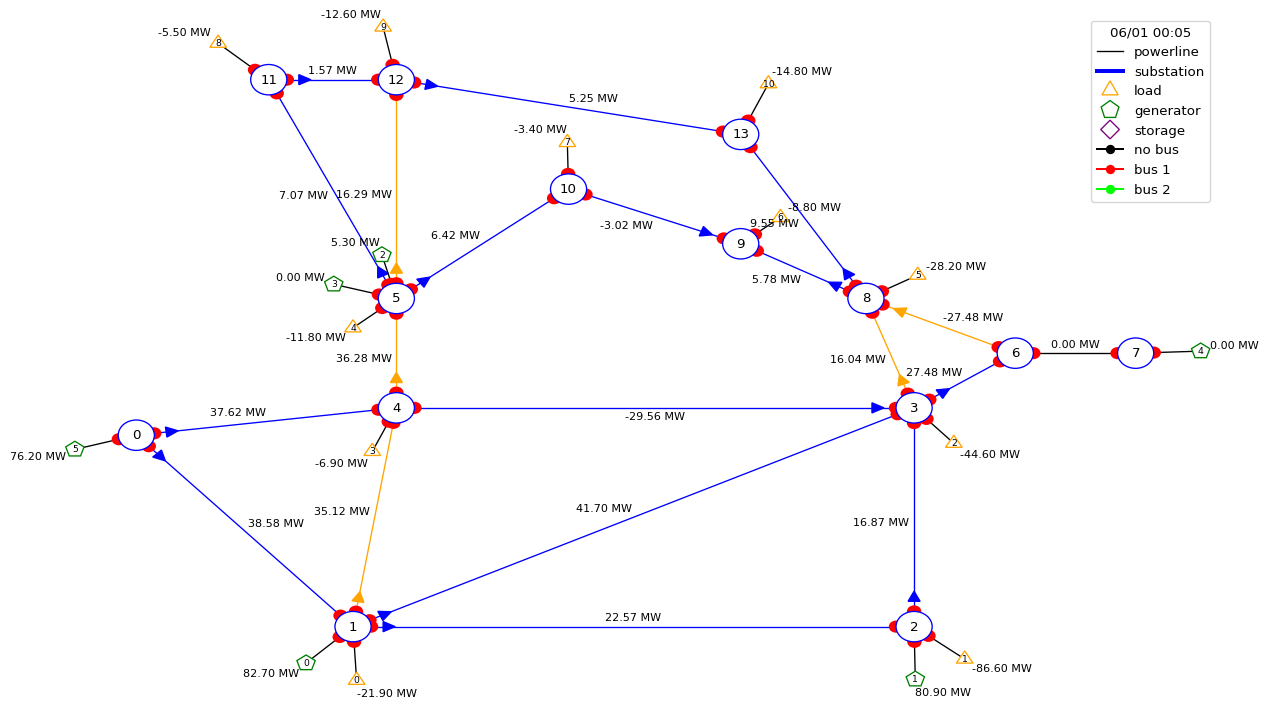

In [640]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
init_obs, *_ = env.simulate(env.action_space())
#get_delta_theta_line(init_obs,id_l2)

print("when l1 and l2 are both connected")
print("delta theta l1: "+str(get_delta_theta_line(init_obs,id_l1)))
print("delta theta l2: "+str(get_delta_theta_line(init_obs,id_l2)))
fig = plot_helper.plot_obs(init_obs,line_info="p")
fig.show()


when l1 and l2 are disconnected
delta theta l1: -0.16183546892600587
delta theta l1: 0.41050156737560695


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2986498964.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


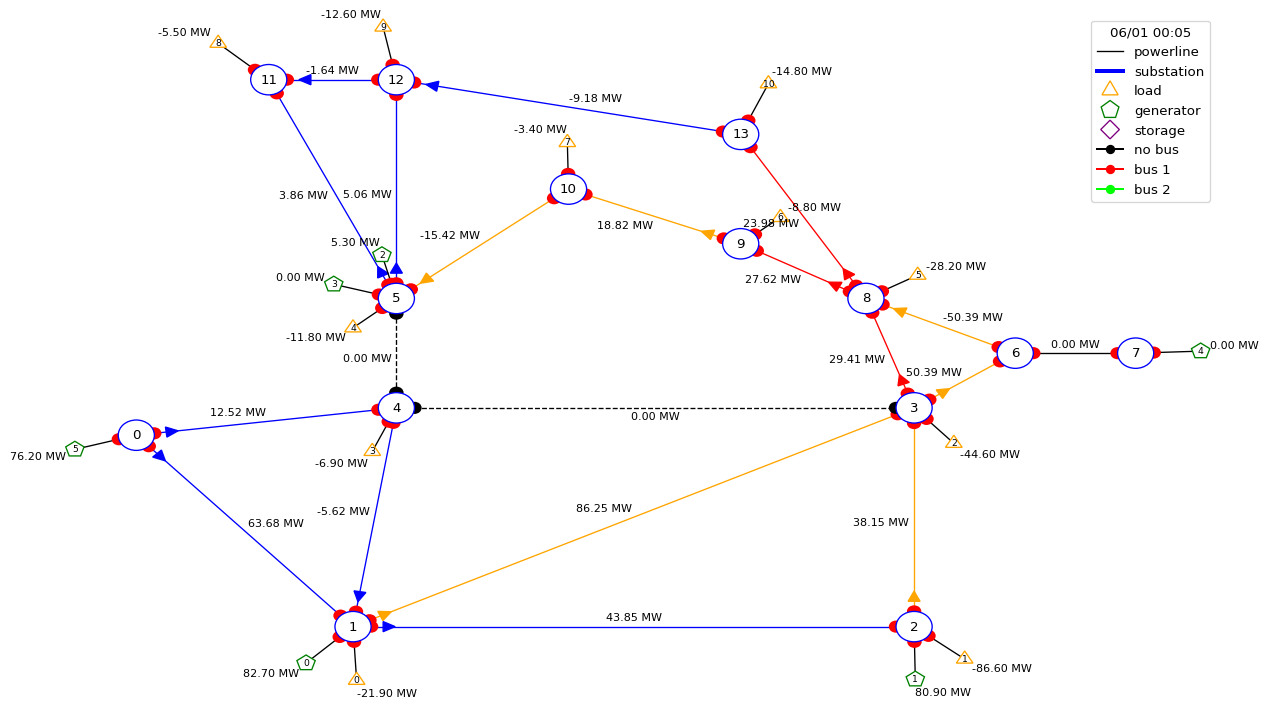

In [641]:
print("when l1 and l2 are disconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2,id_l2)))
fig = plot_helper.plot_obs(obs_disconnected_l1_l2,line_info="p")
fig.show()


when l1 is reconnected
delta theta l1: -0.025333248537010616
delta theta l1: 0.2739993636313544


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/1486352159.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


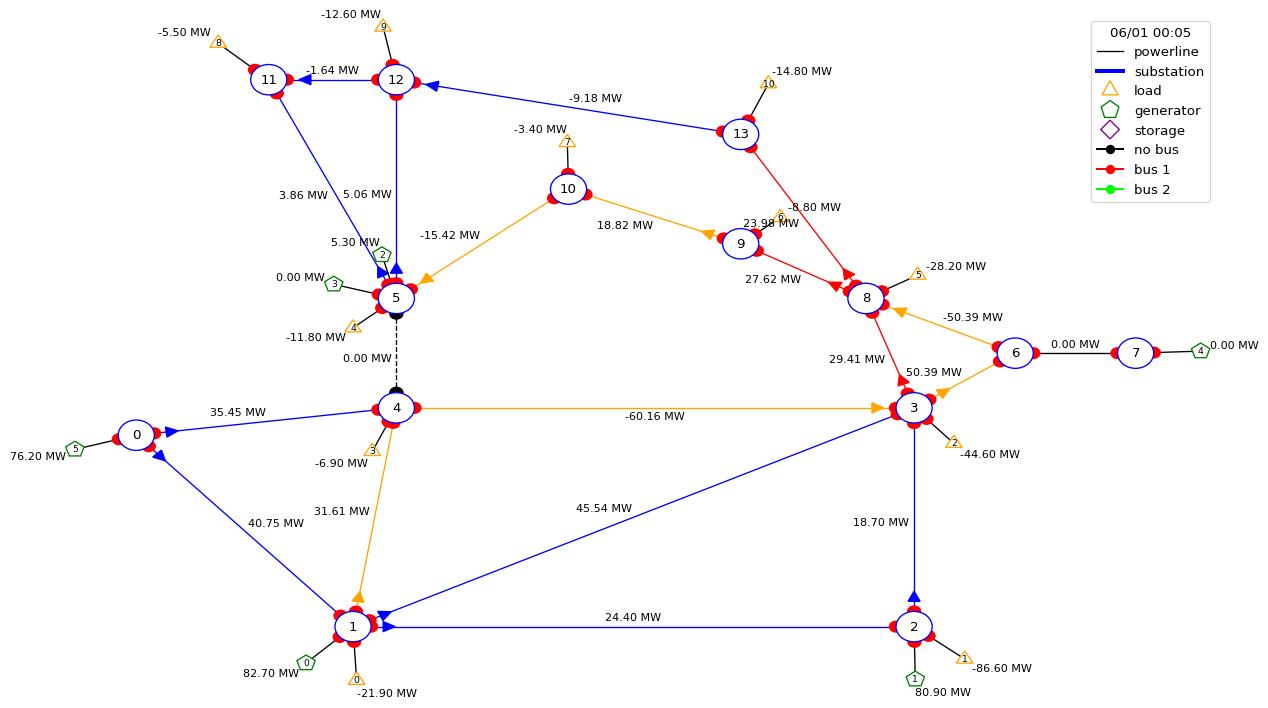

In [642]:
print("when l1 is reconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l2,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l2,id_l2)))
fig = plot_helper.plot_obs(obs_disconnect_l2,line_info="p")
fig.show()


when l2 is reconnected
delta theta l1: -0.06345027952558464
delta theta l1: 0.10184660097519557


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2728517373.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


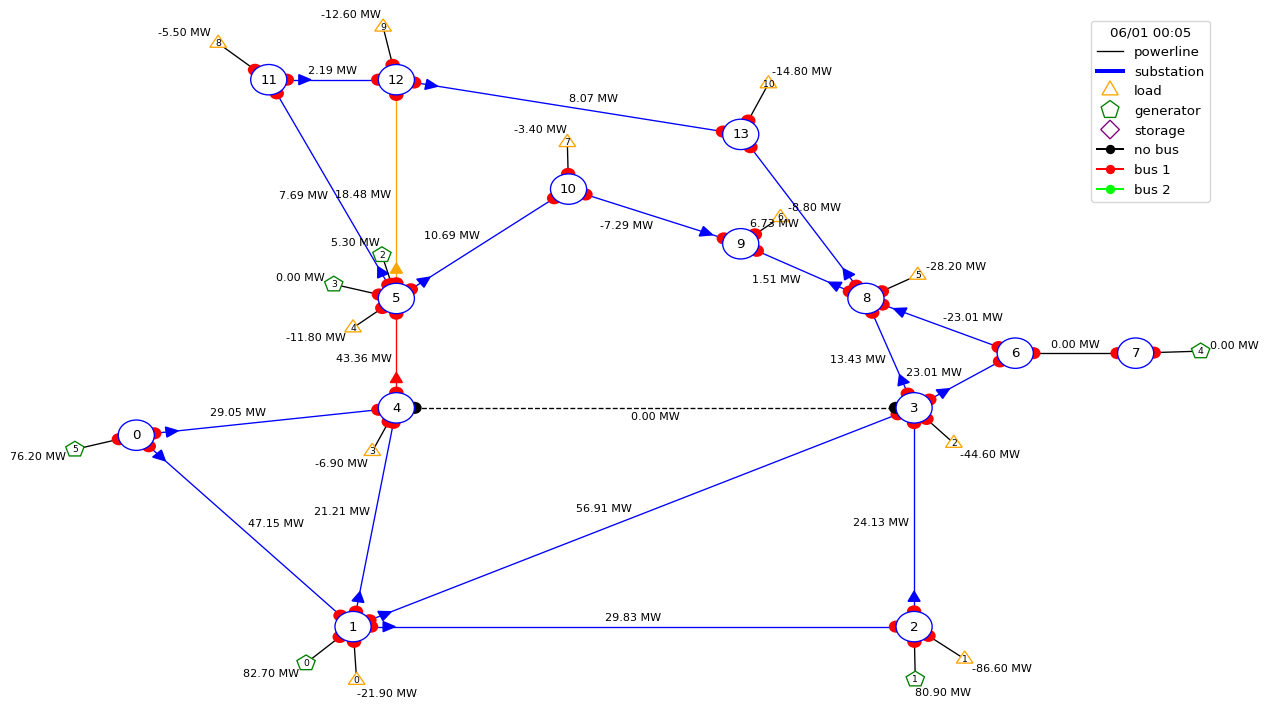

In [643]:
print("when l2 is reconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l1,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l1,id_l2)))
fig = plot_helper.plot_obs(obs_disconnect_l1,line_info="p")
fig.show()


In [646]:
#print(get_delta_theta_line(init_obs,id_l2))
delta_init_l1=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
delta_l1_connected_l1=get_delta_theta_line(obs_disconnect_l2,id_l1)
delta_l2_connected_l1=get_delta_theta_line(obs_disconnect_l1,id_l1)

new_delta_l1=delta_l1_connected_l1*delta_l2_connected_l1/delta_init_l1

#new_delta_l1=delta_l1_connected_l1*(1+(delta_l2_connected_l1/delta_init_l1-1)+(delta_l2_connected_l1/delta_init_l1-1)**2)
print("start for l1 is: "+str(delta_theta_l1_init))
print("only target line reconneceted: "+str(delta_l1_connected_l1))
print(new_delta_l1)

print("target for l1 is: "+str(get_delta_theta_line(init_obs,id_l1)))

start for l1 is: -0.16183546892600587
only target line reconneceted: -0.025333248537010616
-0.009932320223939075
target for l1 is: -0.012448911033285989


In [655]:
#print(get_delta_theta_line(init_obs,id_l2))
delta_init_l2=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)
delta_l1_connected_l2=get_delta_theta_line(obs_disconnect_l2,id_l2)
delta_l2_connected_l2=get_delta_theta_line(obs_disconnect_l1,id_l2)

#new_delta_l2=delta_l2_connected_l2-delta_l2_connected_l2*(delta_init_l2-delta_l1_connected_l2)/delta_init_l2
new_delta_l2=delta_l2_connected_l2*delta_l1_connected_l2/delta_init_l2
#new_delta_l2=delta_l1_connected_l2*(delta_l2_connected_l2-delta_init_l2)/delta_init_l2

print("start for l2 is: "+str(delta_theta_l2_init))
print("only target line reconnected: "+str(delta_l2_connected_l2))
print(new_delta_l2)

print("target for l2 is: "+str(get_delta_theta_line(init_obs,id_l2)))

start for l2 is: 0.41050156737560695
only target line reconnected: 0.10184660097519557
0.06798001779536764
target for l2 is: 0.08520436325520939


## Disconnnecting 3lines

#### Try to find disconnected lines final flows when reconnecting

In [672]:
id_l1=3#2#3
id_l2=7#4#7
id_l3=0#4#7

obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
#obs_disconnected_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_reco_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1),(id_l3, -1)]}))
obs_reco_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l3, -1)]}))
obs_reco_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))



In [657]:


print("for line l1 with id "+str(id_l1))
print("virtual flow when both lines are connected")
delta_thetas=get_delta_theta_line(init_obs,id_l1)
print("delta_theta: "+str(delta_thetas))
print(1/Req_l1*delta_thetas*100)

print("virtual flow when l1 is disconnected")
delta_thetas=get_delta_theta_line(obs_disconnect_l1,id_l1)
print("delta_theta: "+str(delta_thetas))
print(1/Req_l1_line_disco*delta_thetas*100)

print("virtual flow when l2 is disconnected")
R_eq_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l2])
delta_thetas=get_delta_theta_line(obs_disconnect_l2,id_l1)
print("delta_theta: "+str(delta_thetas))
print(1/R_eq_l2_disconnected[sub_l1_or][sub_l1_ex]*delta_thetas*100)

print("virtual flow when l1 and l2 are disconnected")
R_eq_l1_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1,id_l2])
delta_thetas=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
print("delta_theta: "+str(delta_thetas))
print(1/R_eq_l1_l2_disconnected[sub_l1_or][sub_l1_ex]*delta_thetas*100)

for line l1 with id 3
virtual flow when both lines are connected
delta_theta: 0.07351858038769828
(111.50605018683592+0j)
virtual flow when l1 is disconnected
delta_theta: 0.10033645675463147
(95.27499104519143+0j)
virtual flow when l2 is disconnected
delta_theta: 0.08029350667550829
(121.47143274732264+0j)
virtual flow when l1 and l2 are disconnected
delta_theta: 0.08868303958940506
(83.86683281184027+0j)


In [658]:
print("for line l2 with id "+str(id_l2))
print("virtual flow when both lines are connected")
delta_thetas=get_delta_theta_line(init_obs,id_l2)
print("delta_theta: "+str(delta_thetas))
print(1/Req_l2*delta_thetas*100)

print("virtual flow when l1 is disconnected")
delta_thetas=get_delta_theta_line(obs_disconnect_l1,id_l2)
print("delta_theta: "+str(delta_thetas))
R_eq_l1_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1])
print(1/R_eq_l1_disconnected[sub_l2_or][sub_l2_ex]*delta_thetas*100)

print("virtual flow when l2 is disconnected")
delta_thetas=get_delta_theta_line(obs_disconnect_l2,id_l2)
print("delta_theta: "+str(delta_thetas))
#R_eq_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l2])
print(1/Req_l2_line_disco*delta_thetas*100)

print("virtual flow when l1 and l2 are disconnected")
delta_thetas=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)
print("delta_theta: "+str(delta_thetas))
R_eq_l1_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1,id_l2])
print(1/R_eq_l1_l2_disconnected[sub_l2_or][sub_l2_ex]*delta_thetas*100)

for line l2 with id 7
virtual flow when both lines are connected
delta_theta: 0.012771660917652977
(8.699627762841367+0j)
virtual flow when l1 is disconnected
delta_theta: 0.021257983010662927
(14.47239370808903+0j)
virtual flow when l2 is disconnected
delta_theta: -0.03067632747417026
(-5.472696907021092+0j)
virtual flow when l1 and l2 are disconnected
delta_theta: 0.05844863003534741
(10.405776578799081+0j)


In [662]:
delta_theta_l1_init=get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l1)
delta_theta_l2_init=get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l2)
delta_theta_l3_init=get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l3)

print("start for l1 is: "+str(delta_theta_l1_init))
print("start for l2 is: "+str(delta_theta_l2_init))
print("start for l3 is: "+str(delta_theta_l3_init))

print("connect l1 for l1 is: "+str(get_delta_theta_line(obs_reco_l1,id_l1)))
print("connect l2 for l2 is: "+str(get_delta_theta_line(obs_reco_l2,id_l2)))
print("connect l3 for l3 is: "+str(get_delta_theta_line(obs_reco_l3,id_l3)))

#print("connect l1 for l2 is: "+str(get_delta_theta_line(obs_disconnect_l2,id_l2)))
#print("connect l2 for l1 is: "+str(get_delta_theta_line(obs_disconnect_l1,id_l1)))

print("target for l1 is: "+str(get_delta_theta_line(init_obs,id_l1)))
print("target for l2 is: "+str(get_delta_theta_line(init_obs,id_l2)))

start for l1 is: 0.08868303958940506
start for l2 is: 0.05844863003534741
start for l3 is: 0.11062034448607763
connect l1 for l1 is: 0.05012204753854539
connect l2 for l2 is: 0.015281837927606368
connect l3 for l3 is: 0.016190469233052597
target for l1 is: 0.07351858038769828
target for l2 is: 0.012771660917652977


when l1 and l2 are both connected
delta theta l1: 0.07351858038769828
delta theta l2: 0.012771660917652977


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2982464311.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


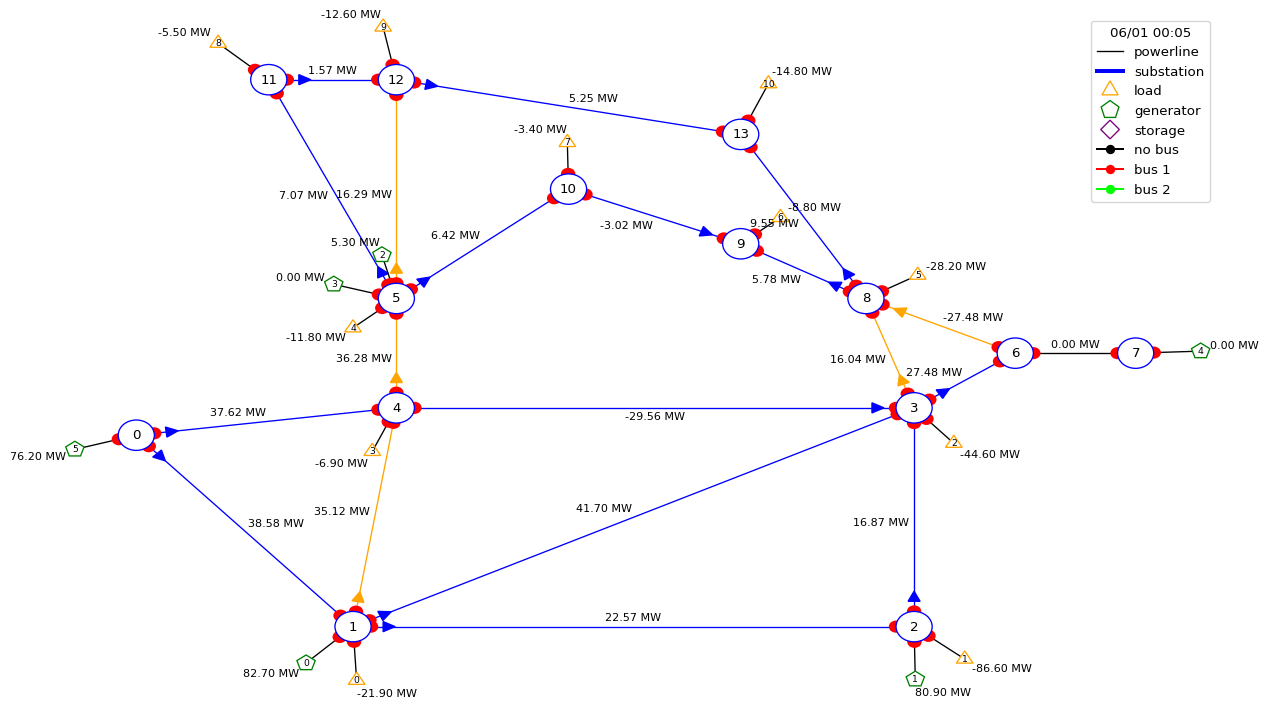

In [663]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
init_obs, *_ = env.simulate(env.action_space())
#get_delta_theta_line(init_obs,id_l2)

print("when l1 and l2 are both connected")
print("delta theta l1: "+str(get_delta_theta_line(init_obs,id_l1)))
print("delta theta l2: "+str(get_delta_theta_line(init_obs,id_l2)))
fig = plot_helper.plot_obs(init_obs,line_info="p")
fig.show()


when l1 and l2 and l3 are disconnected
delta theta l1: 0.08868303958940506
delta theta l1: 0.05844863003534741
delta theta l1: 0.11062034448607763


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/576497485.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


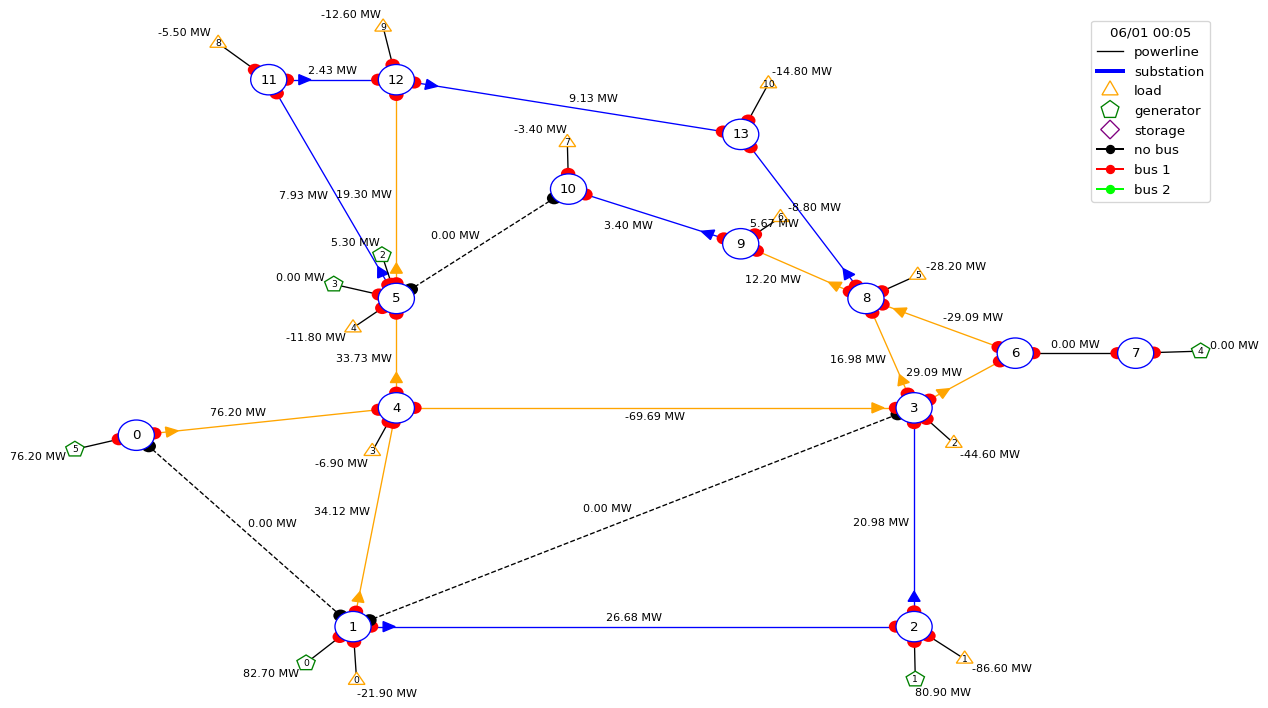

In [664]:
print("when l1 and l2 and l3 are disconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l2)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l3)))
fig = plot_helper.plot_obs(obs_disconnected_l1_l2,line_info="p")
fig.show()


when l1 is reconnected
delta theta l1: 0.05012204753854539
delta theta l2: 0.05389070025862588
delta theta l3: 0.14187807282463707


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/1350160254.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


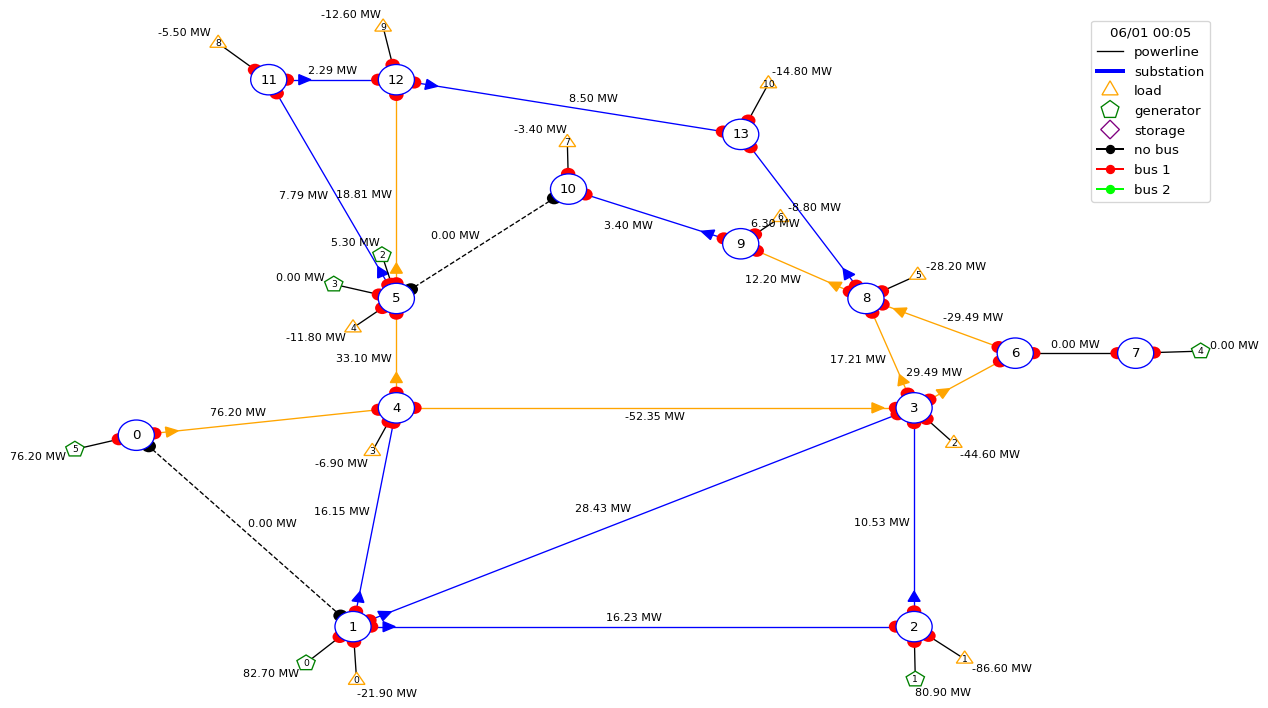

In [665]:
print("when l1 is reconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_reco_l1,id_l1)))
print("delta theta l2: "+str(get_delta_theta_line(obs_reco_l1,id_l2)))
print("delta theta l3: "+str(get_delta_theta_line(obs_reco_l1,id_l3)))
fig = plot_helper.plot_obs(obs_reco_l1,line_info="p")
fig.show()


when l2 is reconnected
delta theta l1: 0.08745112888871298
delta theta l2: 0.015281837927606368
delta theta l3: 0.11003984243779712


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/3980258.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


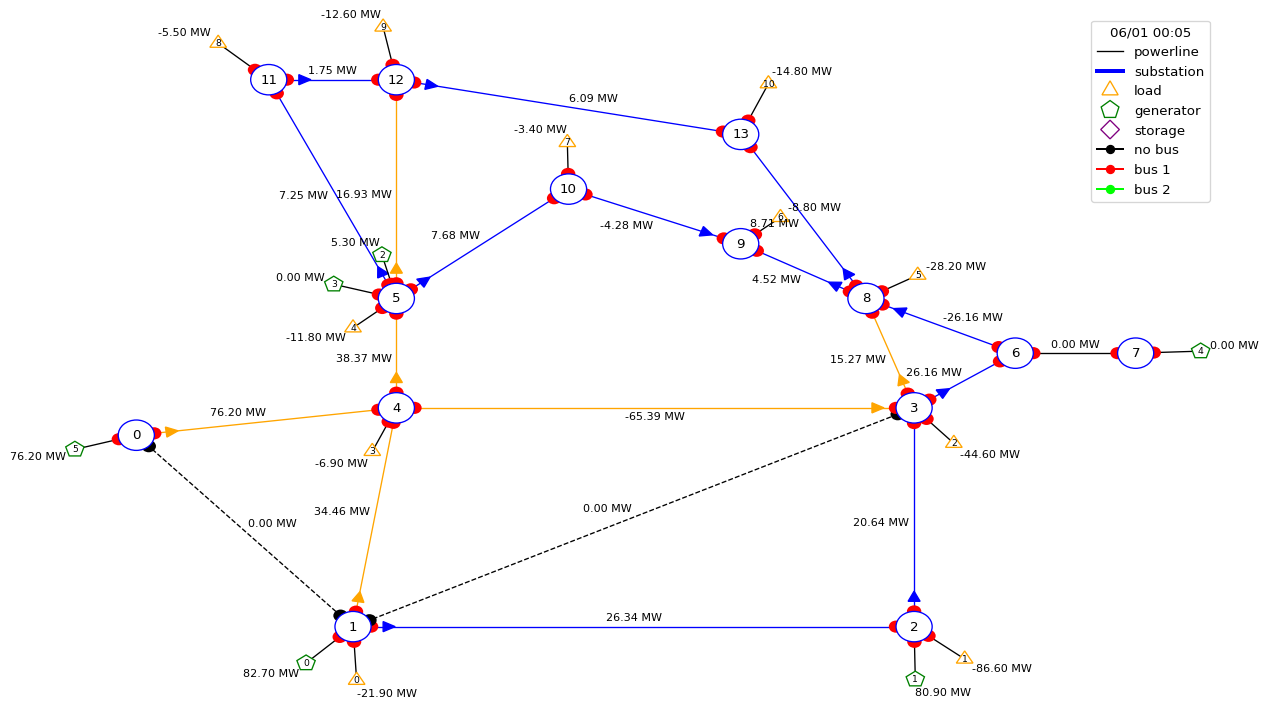

In [666]:
print("when l2 is reconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_reco_l2,id_l1)))
print("delta theta l2: "+str(get_delta_theta_line(obs_reco_l2,id_l2)))
print("delta theta l3: "+str(get_delta_theta_line(obs_reco_l2,id_l3)))
fig = plot_helper.plot_obs(obs_reco_l2,line_info="p")
fig.show()


when l2 is reconnected
delta theta l1: 0.11877069244660271
delta theta l2: 0.056381219827387065
delta theta l3: 0.016190469233052597


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/3830396272.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


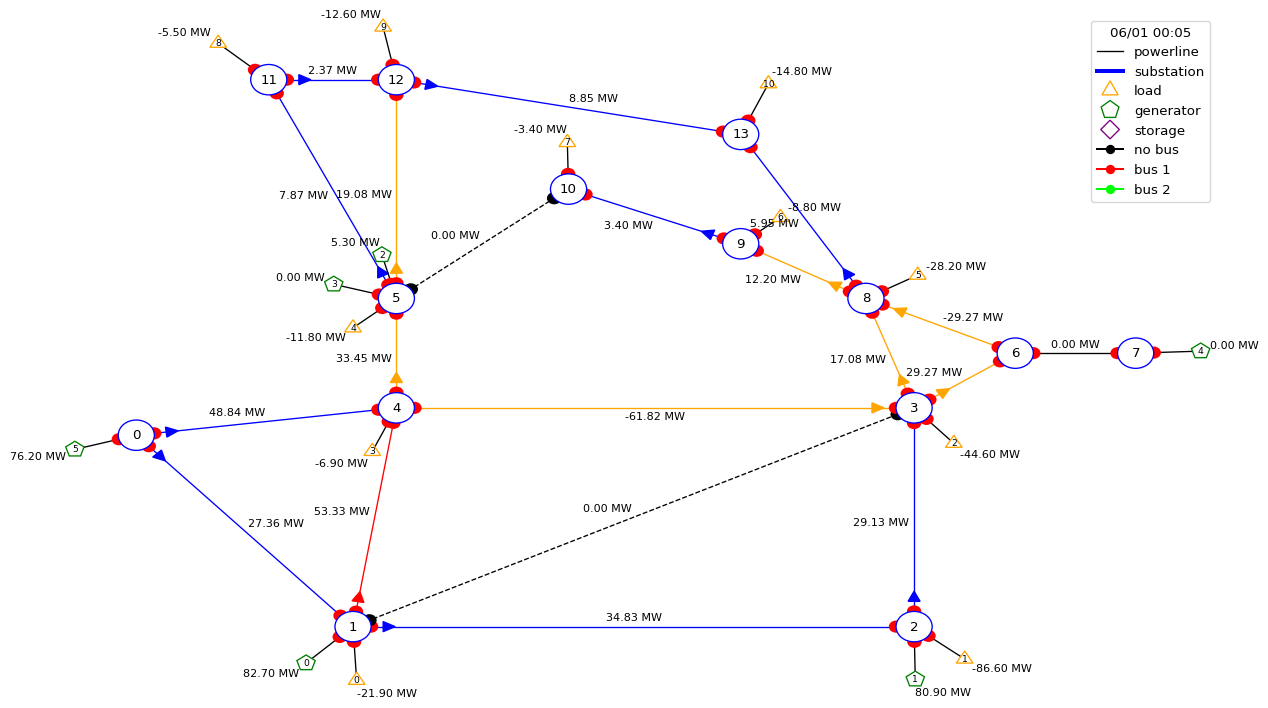

In [675]:
print("when l2 is reconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_reco_l3,id_l1)))
print("delta theta l2: "+str(get_delta_theta_line(obs_reco_l3,id_l2)))
print("delta theta l3: "+str(get_delta_theta_line(obs_reco_l3,id_l3)))
fig = plot_helper.plot_obs(obs_reco_l3,line_info="p")
fig.show()


In [673]:
#print(get_delta_theta_line(init_obs,id_l2))
delta_theta_l1_init=get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l1)
delta_l1_connected_l1=get_delta_theta_line(obs_reco_l1,id_l1)
delta_l2_connected_l1=get_delta_theta_line(obs_reco_l2,id_l1)
delta_l3_connected_l1=get_delta_theta_line(obs_reco_l3,id_l1)

new_delta_l1=delta_l1_connected_l1*delta_l2_connected_l1/delta_theta_l1_init*delta_l3_connected_l1/delta_theta_l1_init

#new_delta_l1=delta_l1_connected_l1*(1+(delta_l2_connected_l1/delta_init_l1-1)+(delta_l2_connected_l1/delta_init_l1-1)**2)
print("start for l1 is: "+str(delta_theta_l1_init))
print("only target line reconneceted: "+str(delta_l1_connected_l1))
print(new_delta_l1)

print("target for l1 is: "+str(get_delta_theta_line(init_obs,id_l1)))

start for l1 is: 0.08868303958940506
only target line reconneceted: 0.05012204753854539
0.06619457109803135
target for l1 is: 0.07351858038769828


In [674]:
#print(get_delta_theta_line(init_obs,id_l2))
delta_theta_l2_init=get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l2)
delta_l1_connected_l2=get_delta_theta_line(obs_reco_l1,id_l2)
delta_l2_connected_l2=get_delta_theta_line(obs_reco_l2,id_l2)
delta_l3_connected_l2=get_delta_theta_line(obs_reco_l3,id_l2)

#new_delta_l2=delta_l2_connected_l2-delta_l2_connected_l2*(delta_init_l2-delta_l1_connected_l2)/delta_init_l2
new_delta_l2=delta_l2_connected_l2*delta_l1_connected_l2/delta_theta_l2_init*delta_l3_connected_l2/delta_theta_l2_init
#new_delta_l2=delta_l1_connected_l2*(delta_l2_connected_l2-delta_init_l2)/delta_init_l2

print("start for l2 is: "+str(delta_theta_l2_init))
print("only target line reconnected: "+str(delta_l2_connected_l2))
print(new_delta_l2)

print("target for l2 is: "+str(get_delta_theta_line(init_obs,id_l2)))

start for l2 is: 0.05844863003534741
only target line reconnected: 0.015281837927606368
0.013591744797439726
target for l2 is: 0.012771660917652977


In [347]:
alpha=0.009389883438962413*4.243397805569337
print(alpha)
print(alpha+alpha**2)
print(alpha+alpha**2+alpha**3)

0.03984501077944497
0.041432635663459054
0.04149589459407631


In [414]:
delta_theta_l1_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
delta_theta_l2_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)

print("start for l1 is: "+str(delta_l1_init))
print("start for l2 is: "+str(delta_l2_init))

print("connect l1 for l1 is: "+str(get_delta_theta_line(obs_disconnect_l2,id_l1)))
print("connect l2 for l2 is: "+str(get_delta_theta_line(obs_disconnect_l1,id_l2)))

print("target for l1 is: "+str(get_delta_theta_line(init_obs,id_l1)))
print("target for l2 is: "+str(get_delta_theta_line(init_obs,id_l2)))

ratio_change_delta_theta_l2_connect_l1=(delta_theta_l2_init-get_delta_theta_line(obs_disconnect_l2,id_l2))/delta_theta_l2_init
ratio_change_delta_theta_l1_connect_l1=(delta_theta_l1_init-get_delta_theta_line(obs_disconnect_l2,id_l1))/delta_theta_l1_init
ratio_l1_to_l2=(ratio_change_delta_theta_l2_connect_l1)/\
                (ratio_change_delta_theta_l1_connect_l1)
print("ratio_l1_to_l2 is "+str(ratio_l1_to_l2))

ratio_change_delta_theta_l2_connect_l2=(delta_theta_l2_init-get_delta_theta_line(obs_disconnect_l1,id_l2))/delta_theta_l2_init
ratio_change_delta_theta_l1_connect_l2=(delta_theta_l1_init-get_delta_theta_line(obs_disconnect_l1,id_l1))/delta_theta_l1_init
ratio_l2_to_l1=(ratio_change_delta_theta_l1_connect_l2)/\
                (ratio_change_delta_theta_l2_connect_l2)
print("ratio_l2_to_l1 is "+str(ratio_l2_to_l1))

print("ratio_change_delta_theta_l1_connect_l1 is "+str(ratio_change_delta_theta_l1_connect_l1))
print("ratio_change_delta_theta_l2_connect_l2 is "+str(ratio_change_delta_theta_l2_connect_l2))


#round 1
print("round 1")
delta_l1_round1=get_delta_theta_line(obs_disconnect_l2,id_l1)
delta_l2_round1=delta_l2_init-(delta_l1_init-delta_l1_round1)*ratio_l1_to_l2
print(delta_l1_round1)
print(delta_l2_round1)
print(get_delta_theta_line(obs_disconnect_l2,id_l2))

#round 2
print("round 2")
#delta_l2_round2=delta_l2_round1*change_delta_theta_l2_connect_l2
delta_l2_round2=delta_l2_round1#(1-*ratio_change_delta_theta_l2_connect_l2)
delta_l1_round2=delta_l1_round1-(delta_l2_round1-delta_l2_round2)*ratio_l2_to_l1

print(delta_l1_round2)
print(delta_l2_round2)
#print(get_delta_theta_line(obs_disconnect_l2,id_l2))

print("round 3")
delta_l1_round3=delta_l1_round2#delta_l1_round2 -(delta_l1_round1-delta_l1_round2)*ratio_change_delta_theta_l1_connect_l1
delta_l2_round3=delta_l2_round2-(delta_l1_round2-delta_l1_round3)*ratio_l1_to_l2

print(delta_l1_round3)
print(delta_l2_round3)

print("round 4")

delta_l2_round4=delta_l2_round3#delta_l2_round3 -(delta_l2_round2-delta_l2_round3)*ratio_change_delta_theta_l2_connect_l2
delta_l1_round4=delta_l1_round3-(delta_l2_round3-delta_l2_round4)*ratio_l2_to_l1

print(delta_l1_round4)
print(delta_l2_round4)

#delta_l2_round4=delta_l2_round1+(delta_l2_round1-delta_l2_round2)*ratio_change_delta_theta_l2_connect_l2
#print(delta_l2_round3)


start for l1 is: 0.092736250831604
start for l2 is: 0.056381219827387065
connect l1 for l1 is: 0.060414923431078585
connect l2 for l2 is: 0.014744029644489287
target for l1 is: 0.06106967351559798
target for l2 is: 0.012771660917652977
ratio_l1_to_l2 is 0.38761566386267576
ratio_l2_to_l1 is -0.005708804028394688
ratio_change_delta_theta_l1_connect_l1 is 0.3485295891378702
ratio_change_delta_theta_l2_connect_l2 is 0.73849395792378
round 1
0.060414923431078585
0.04385296705010951
0.048764369161605835
round 2
0.060414923431078585
0.04385296705010951
round 3
0.060414923431078585
0.04385296705010951
round 4
0.060414923431078585
0.04385296705010951


In [436]:
delta_theta_l1_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
delta_theta_l2_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)

print("start for l1 is: "+str(delta_l1_init))
print("start for l2 is: "+str(delta_l2_init))

print("connect l1 for l1 is: "+str(get_delta_theta_line(obs_disconnect_l2,id_l1)))
print("connect l2 for l2 is: "+str(get_delta_theta_line(obs_disconnect_l1,id_l2)))

print("target for l1 is: "+str(get_delta_theta_line(init_obs,id_l1)))
print("target for l2 is: "+str(get_delta_theta_line(init_obs,id_l2)))

change_delta_theta_l2_connect_l1=(delta_theta_l2_init-get_delta_theta_line(obs_disconnect_l2,id_l2))#/delta_theta_l2_init
change_delta_theta_l1_connect_l1=(delta_theta_l1_init-get_delta_theta_line(obs_disconnect_l2,id_l1))#/delta_theta_l1_init
ratio_l1_to_l2=(change_delta_theta_l2_connect_l1)/\
                (change_delta_theta_l1_connect_l1)

ratio_change_delta_theta_l2_connect_l1=change_delta_theta_l2_connect_l1/delta_theta_l2_init
ratio_change_delta_theta_l1_connect_l1=change_delta_theta_l1_connect_l1/delta_theta_l1_init
print("ratio_l1_to_l2 is "+str(ratio_l1_to_l2))

change_delta_theta_l2_connect_l2=(delta_theta_l2_init-get_delta_theta_line(obs_disconnect_l1,id_l2))#/delta_theta_l2_init
change_delta_theta_l1_connect_l2=(delta_theta_l1_init-get_delta_theta_line(obs_disconnect_l1,id_l1))#/delta_theta_l1_init
ratio_l2_to_l1=(change_delta_theta_l1_connect_l2)/\
                (change_delta_theta_l2_connect_l2)

ratio_change_delta_theta_l2_connect_l2=change_delta_theta_l2_connect_l2/delta_theta_l2_init
ratio_change_delta_theta_l1_connect_l2=change_delta_theta_l1_connect_l2/delta_theta_l1_init
print("ratio_l2_to_l1 is "+str(ratio_l2_to_l1))

print("ratio_change_delta_theta_l1_connect_l1 is "+str(ratio_change_delta_theta_l1_connect_l1))
print("ratio_change_delta_theta_l2_connect_l2 is "+str(ratio_change_delta_theta_l2_connect_l2))


#round 1
print("round 1")

delta_l2_round1=delta_theta_l2_init*(1-ratio_change_delta_theta_l2_connect_l2)#get_delta_theta_line(obs_disconnect_l1,id_l2)  
delta_l1_round1=delta_l1_init+(delta_l2_round1-delta_l2_init)*ratio_l2_to_l1
print(delta_l1_round1)
print(delta_l2_round1)
#print(get_delta_theta_line(obs_disconnect_l2,id_l2))

#round 2
print("round 2")
#delta_l2_round2=delta_l2_round1*change_delta_theta_l2_connect_l2
delta_l1_round2=delta_l1_round1*(1-ratio_change_delta_theta_l1_connect_l1)
delta_l2_round2=delta_l2_round1+(delta_l1_round2-delta_l1_round1)*ratio_l1_to_l2

print(delta_l1_round2)
print(delta_l2_round2)
#print(get_delta_theta_line(obs_disconnect_l2,id_l2))

print("round 3")
delta_l2_round3=delta_l2_round2+(delta_l2_round1-delta_l2_round2)*ratio_change_delta_theta_l2_connect_l2#delta_l1_round2 -(delta_l1_round1-delta_l1_round2)*ratio_change_delta_theta_l1_connect_l1
delta_l1_round3=delta_l1_round2+(delta_l2_round3-delta_l2_round2)*ratio_l2_to_l1

print(delta_l1_round3)
print(delta_l2_round3)

print("round 4")

delta_l1_round4=delta_l1_round3+(delta_l1_round2-delta_l1_round3)*ratio_change_delta_theta_l1_connect_l1
delta_l2_round4=delta_l2_round3-(delta_l1_round4-delta_l1_round3)*ratio_l1_to_l2#delta_l2_round3 -(delta_l2_round2-delta_l2_round3)*ratio_change_delta_theta_l2_connect_l2

print(delta_l1_round4)
print(delta_l2_round4)

#delta_l2_round4=delta_l2_round1+(delta_l2_round1-delta_l2_round2)*ratio_change_delta_theta_l2_connect_l2
#print(delta_l2_round3)


start for l1 is: 0.092736250831604
start for l2 is: 0.056381219827387065
connect l1 for l1 is: 0.060414923431078585
connect l2 for l2 is: 0.014744029644489287
target for l1 is: 0.06106967351559798
target for l2 is: 0.012771660917652977
ratio_l1_to_l2 is 0.23566020576424132
ratio_l2_to_l1 is -0.009389883438962413
ratio_change_delta_theta_l1_connect_l1 is 0.3485295891378702
ratio_change_delta_theta_l2_connect_l2 is 0.73849395792378
round 1
0.09312721919414732
0.014744029644489289
round 2
0.06066962775085878
0.007095066966352233
round 3
0.06071882758588297
0.0018554028806365055
round 4
0.06070167998759634
0.0018594438871770954


In [ ]:
min_delta_theta_l1=get_delta_theta_line(obs_disconnect_l2,id_l1)
min_delta_theta_l2=get_delta_theta_line(obs_disconnect_l1,id_l2)

In [449]:
delta_theta_l1_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
delta_theta_l2_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)

In [453]:
res_delta_theta_l1=get_delta_theta_line(obs_disconnect_l1,id_l1)*(1-ratio_change_delta_theta_l1_connect_l1)
print(res_delta_theta_l1)

0.06066962775085878


In [452]:
get_delta_theta_line(obs_disconnect_l1,id_l2)

0.014744029644489287

In [ ]:
get_delta_theta_line(obs_disconnect_l1,id_l1)(min_delta_theta_l1-delta_theta_l1_init)

In [468]:
delta_theta_l1_init

0.092736250831604

In [455]:
delta_theta_l1_target=get_delta_theta_line(init_obs,id_l1)
delta_theta_l1_target

0.06106967351559798

In [466]:
alpha=0.98
beta=0.02
delta_theta_l1_init+alpha*(get_delta_theta_line(obs_disconnect_l2,id_l1)-delta_theta_l1_init)\
    +beta*(get_delta_theta_line(obs_disconnect_l1,id_l1)-delta_theta_l1_init)

0.06106916934633996

In [477]:
init_obs.p_or[id_l1]/obs_disconnect_l2.p_or[id_l1]

1.0108376

In [469]:
delta_theta_l2_init

0.056381219827387065

In [467]:
delta_theta_l2_target=get_delta_theta_line(init_obs,id_l2)
delta_theta_l2_target

0.012771660917652977

In [472]:
init_obs.p_or[id_l1]/obs_disconnect_l2.p_or[id_l1]

1.0108376

In [474]:
obs_disconnect_l2.p_or[id_l1]

34.745213

In [505]:
1/(1.058+0.058)

0.8960573476702508

In [503]:
alpha=1.058
beta=-0.058
delta_theta_l2_init+alpha*(get_delta_theta_line(obs_disconnect_l1,id_l2)-delta_theta_l2_init)\
    +beta*(get_delta_theta_line(obs_disconnect_l2,id_l2)-delta_theta_l2_init)

0.012770849952496525

In [476]:
init_obs.p_or[id_l2]/obs_disconnect_l1.p_or[id_l2]

0.8662253

In [448]:
delta_theta_l1_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
delta_theta_l2_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)

print("start for l1 is: "+str(delta_l1_init))
print("start for l2 is: "+str(delta_l2_init))

print("connect l1 for l1 is: "+str(get_delta_theta_line(obs_disconnect_l2,id_l1)))
print("connect l2 for l2 is: "+str(get_delta_theta_line(obs_disconnect_l1,id_l2)))
print("connect l2 for l1 is: "+str(get_delta_theta_line(obs_disconnect_l2,id_l2)))
print("connect l1 for l2 is: "+str(get_delta_theta_line(obs_disconnect_l1,id_l1)))

print("target for l1 is: "+str(get_delta_theta_line(init_obs,id_l1)))
print("target for l2 is: "+str(get_delta_theta_line(init_obs,id_l2)))

change_delta_theta_l2_connect_l1=(delta_theta_l2_init-get_delta_theta_line(obs_disconnect_l2,id_l2))#/delta_theta_l2_init
change_delta_theta_l1_connect_l1=(delta_theta_l1_init-get_delta_theta_line(obs_disconnect_l2,id_l1))#/delta_theta_l1_init
ratio_l1_to_l2=(change_delta_theta_l2_connect_l1)/\
                (change_delta_theta_l1_connect_l1)

ratio_change_delta_theta_l2_connect_l1=change_delta_theta_l2_connect_l1/delta_theta_l2_init
ratio_change_delta_theta_l1_connect_l1=change_delta_theta_l1_connect_l1/delta_theta_l1_init
print("ratio_l1_to_l2 is "+str(ratio_l1_to_l2))

change_delta_theta_l2_connect_l2=(delta_theta_l2_init-get_delta_theta_line(obs_disconnect_l1,id_l2))#/delta_theta_l2_init
change_delta_theta_l1_connect_l2=(delta_theta_l1_init-get_delta_theta_line(obs_disconnect_l1,id_l1))#/delta_theta_l1_init
ratio_l2_to_l1=(change_delta_theta_l1_connect_l2)/\
                (change_delta_theta_l2_connect_l2)

ratio_change_delta_theta_l2_connect_l2=change_delta_theta_l2_connect_l2/delta_theta_l2_init
ratio_change_delta_theta_l1_connect_l2=change_delta_theta_l1_connect_l2/delta_theta_l1_init
print("ratio_l2_to_l1 is "+str(ratio_l2_to_l1))

print("ratio_change_delta_theta_l1_connect_l1 is "+str(ratio_change_delta_theta_l1_connect_l1))
print("ratio_change_delta_theta_l2_connect_l2 is "+str(ratio_change_delta_theta_l2_connect_l2))


#round 1
print("round 1")

delta_l2_round1=(get_delta_theta_line(obs_disconnect_l2,id_l2))*(1-ratio_change_delta_theta_l2_connect_l2)#get_delta_theta_line(obs_disconnect_l1,id_l2)
delta_l1_round1=(get_delta_theta_line(obs_disconnect_l1,id_l1))*(1-ratio_change_delta_theta_l1_connect_l1)
print(delta_l1_round1)
print(delta_l2_round1)
#print(get_delta_theta_line(obs_disconnect_l2,id_l2))

res_delta_l1=(delta_theta_l1_init+get_delta_theta_line(obs_disconnect_l1,id_l1))*ratio_change_delta_theta_l1_connect_l1
res_delta_l2=(delta_theta_l2_init+get_delta_theta_line(obs_disconnect_l2,id_l2))*ratio_change_delta_theta_l2_connect_l2
print(res_delta_l1)
print(res_delta_l2)
#round 2
print("round 2")
#delta_l2_round2=delta_l2_round1*change_delta_theta_l2_connect_l2
delta_l1_round2=delta_l1_round1*(1-ratio_change_delta_theta_l1_connect_l1)
delta_l2_round2=delta_l2_round1+(delta_l1_round2-delta_l1_round1)*ratio_l1_to_l2

print(delta_l1_round2)
print(delta_l2_round2)
#print(get_delta_theta_line(obs_disconnect_l2,id_l2))

print("round 3")
delta_l2_round3=delta_l2_round2+(delta_l2_round1-delta_l2_round2)*ratio_change_delta_theta_l2_connect_l2#delta_l1_round2 -(delta_l1_round1-delta_l1_round2)*ratio_change_delta_theta_l1_connect_l1
delta_l1_round3=delta_l1_round2+(delta_l2_round3-delta_l2_round2)*ratio_l2_to_l1

print(delta_l1_round3)
print(delta_l2_round3)

print("round 4")

delta_l1_round4=delta_l1_round3+(delta_l1_round2-delta_l1_round3)*ratio_change_delta_theta_l1_connect_l1
delta_l2_round4=delta_l2_round3-(delta_l1_round4-delta_l1_round3)*ratio_l1_to_l2#delta_l2_round3 -(delta_l2_round2-delta_l2_round3)*ratio_change_delta_theta_l2_connect_l2

print(delta_l1_round4)
print(delta_l2_round4)

#delta_l2_round4=delta_l2_round1+(delta_l2_round1-delta_l2_round2)*ratio_change_delta_theta_l2_connect_l2
#print(delta_l2_round3)


start for l1 is: 0.092736250831604
start for l2 is: 0.056381219827387065
connect l1 for l1 is: 0.060414923431078585
connect l2 for l2 is: 0.014744029644489287
connect l2 for l1 is: 0.048764369161605835
connect l1 for l2 is: 0.09312721919414732
target for l1 is: 0.06106967351559798
target for l2 is: 0.012771660917652977
ratio_l1_to_l2 is 0.23566020576424132
ratio_l2_to_l1 is -0.009389883438962413
ratio_change_delta_theta_l1_connect_l1 is 0.3485295891378702
ratio_change_delta_theta_l2_connect_l2 is 0.73849395792378
round 1
0.06066962775085878
0.01275217717379522
0.06477891884381395
0.0776493821707084
round 2
0.03952446731770445
0.007769104315200175
round 3
0.03948991283587657
0.011449073513166593
round 4
0.03950195609523091
0.011446235396189077


In [439]:
0.060414923431078585+0.00761685066578123

0.06803177409685982

In [418]:
delta_theta_l1_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
delta_theta_l2_init=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)

print("start for l1 is: "+str(delta_l1_init))
print("start for l2 is: "+str(delta_l2_init))

print("connect l1 for l1 is: "+str(get_delta_theta_line(obs_disconnect_l2,id_l1)))
print("connect l2 for l2 is: "+str(get_delta_theta_line(obs_disconnect_l1,id_l2)))

print("target for l1 is: "+str(get_delta_theta_line(init_obs,id_l1)))
print("target for l2 is: "+str(get_delta_theta_line(init_obs,id_l2)))

ratio_change_delta_theta_l2_connect_l1=(delta_theta_l2_init-get_delta_theta_line(obs_disconnect_l2,id_l2))/delta_theta_l2_init
ratio_change_delta_theta_l1_connect_l1=(delta_theta_l1_init-get_delta_theta_line(obs_disconnect_l2,id_l1))/delta_theta_l1_init
ratio_l1_to_l2=(ratio_change_delta_theta_l2_connect_l1)/\
                (ratio_change_delta_theta_l1_connect_l1)
print("ratio_l1_to_l2 is "+str(ratio_l1_to_l2))

ratio_change_delta_theta_l2_connect_l2=(delta_theta_l2_init-get_delta_theta_line(obs_disconnect_l1,id_l2))/delta_theta_l2_init
ratio_change_delta_theta_l1_connect_l2=(delta_theta_l1_init-get_delta_theta_line(obs_disconnect_l1,id_l1))/delta_theta_l1_init
ratio_l2_to_l1=(ratio_change_delta_theta_l1_connect_l2)/\
                (ratio_change_delta_theta_l2_connect_l2)
print("ratio_l2_to_l1 is "+str(ratio_l2_to_l1))

print("ratio_change_delta_theta_l1_connect_l1 is "+str(ratio_change_delta_theta_l1_connect_l1))
print("ratio_change_delta_theta_l2_connect_l2 is "+str(ratio_change_delta_theta_l2_connect_l2))


#round 1
print("round 1")
delta_l1_round1=get_delta_theta_line(obs_disconnect_l2,id_l1)
delta_l2_round1=get_delta_theta_line(obs_disconnect_l1,id_l2)
print(delta_l1_round1)
print(delta_l2_round1)
#print(get_delta_theta_line(obs_disconnect_l2,id_l2))

#round 2
print("round 2")
#delta_l2_round2=delta_l2_round1*change_delta_theta_l2_connect_l2
delta_l2_round2=delta_l2_round1-(delta_theta_l1_init-delta_l1_round1)*ratio_l1_to_l2#(1-*ratio_change_delta_theta_l2_connect_l2)
delta_l1_round2=delta_l1_round1-(delta_theta_l2_init-delta_l2_round1)*ratio_l2_to_l1

print(delta_l1_round2)
print(delta_l2_round2)
#print(get_delta_theta_line(obs_disconnect_l2,id_l2))

print("round 3")
delta_l1_round3=delta_l1_round2#delta_l1_round2 -(delta_l1_round1-delta_l1_round2)*ratio_change_delta_theta_l1_connect_l1
delta_l2_round3=delta_l2_round2-(delta_l1_round2-delta_l1_round3)*ratio_l1_to_l2

print(delta_l1_round3)
print(delta_l2_round3)

print("round 4")

delta_l2_round4=delta_l2_round3#delta_l2_round3 -(delta_l2_round2-delta_l2_round3)*ratio_change_delta_theta_l2_connect_l2
delta_l1_round4=delta_l1_round3-(delta_l2_round3-delta_l2_round4)*ratio_l2_to_l1

print(delta_l1_round4)
print(delta_l2_round4)

#delta_l2_round4=delta_l2_round1+(delta_l2_round1-delta_l2_round2)*ratio_change_delta_theta_l2_connect_l2
#print(delta_l2_round3)


start for l1 is: 0.092736250831604
start for l2 is: 0.056381219827387065
connect l1 for l1 is: 0.060414923431078585
connect l2 for l2 is: 0.014744029644489287
target for l1 is: 0.06106967351559798
target for l2 is: 0.012771660917652977
ratio_l1_to_l2 is 0.38761566386267576
ratio_l2_to_l1 is -0.005708804028394688
ratio_change_delta_theta_l1_connect_l1 is 0.3485295891378702
ratio_change_delta_theta_l2_connect_l2 is 0.73849395792378
round 1
0.060414923431078585
0.014744029644489287
round 2
0.06065262199012575
0.0022157768672117356
round 3
0.06065262199012575
0.0022157768672117356
round 4
0.06065262199012575
0.0022157768672117356


In [398]:
delta_l2_round1*ratio_change_delta_theta_l2_connect_l2

0.03238515120353649

### Scenario 3: disconnecting 3 lines and assessing virtual flow l1, l2, l3 (id=3 and id=7 and id=0)

#### computing virtual flows

In [206]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2,id_l3]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()


[31.48895452  7.69634534 30.28299473]


In [76]:


obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
obs_disconnected_l1_l2_l3.p_or

array([  0.       ,  76.2      ,  26.675291 ,   0.       ,  34.124706 ,
        20.975294 , -69.69147  ,   0.       ,   7.9306   ,  19.302643 ,
        12.2      ,   5.666758 ,   3.4      ,   2.4306002,   9.133243 ,
        29.08973  ,  16.97703  ,  33.733242 ,   0.       , -29.08973  ],
      dtype=float32)

In [77]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [78]:
theta_or=obs_disconnected_l1_l2_l3.theta_or
theta_ex=obs_disconnected_l1_l2_l3.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnected_l1_l2_l3.v_or
v_ex=obs_disconnected_l1_l2_l3.v_or

sub_l1_exv=obs_disconnected_l1_l2_l3.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnected_l1_l2_l3.line_or_to_subid[id_l1]
lines_sub_or_l1=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
lines_sub_ex_l1=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=obs_disconnected_l1_l2_l3.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnected_l1_l2_l3.line_or_to_subid[id_l2]
lines_sub_or_l2=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
lines_sub_ex_l2=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

sub_l3_ex=obs_disconnected_l1_l2_l3.line_ex_to_subid[id_l3]
sub_l3_or=obs_disconnected_l1_l2_l3.line_or_to_subid[id_l3]
lines_sub_or_l3=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_or)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_or)['lines_ex_id'])
lines_sub_ex_l3=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_ex)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_ex)['lines_ex_id'])


init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])

#for ids of thetas, cf previous section where we identified those
delta_theta_l1=theta_or[2]-theta_ex[5]
delta_theta_l2=theta_or[8]-theta_ex[12]
delta_theta_l3=theta_or[1]-theta_or[2]

print(delta_theta_l1)
print(delta_theta_l2)
print(delta_theta_l3)


virtual_flow_l1=get_Virtual_Flows_NK_withReq(delta_theta_l1,Req_l1,R_l1)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
virtual_flow_l2=get_Virtual_Flows_NK_withReq(delta_theta_l2,Req_l2,R_l2)#np.abs(YBus[sub_l2_or,sub_l2_ex]*100*(delta_theta_l2/360*2*3.14159))
virtual_flow_l3=get_Virtual_Flows_NK_withReq(delta_theta_l3,Req_l3,R_l3)#np.abs(YBus[sub_l3_or,sub_l3_ex]*100*(delta_theta_l3/360*2*3.14159))

print(virtual_flow_l1)
print(virtual_flow_l2)
print(virtual_flow_l3)


[  0.         0.        -6.338084   0.        -6.338084  -9.363821
 -11.419252   0.       -14.277535 -14.277535 -16.661572 -16.661572
 -17.252234 -15.439911 -15.71827  -11.419252 -11.419252  -9.737789
 -14.828015 -16.661572]
[  0.        -9.737789  -9.363821   0.        -9.737789 -11.419252
  -9.737789   0.       -15.439911 -15.71827  -17.252234 -17.539446
 -17.626398 -15.71827  -17.539446 -14.828015 -16.661572 -14.277535
 -14.828015 -14.828015]
5.081168
3.3488626
6.338084
(31.488924609641597+0j)
(7.69634085396277+0j)
(30.282969037755336+0j)


In [79]:
#from above virtual flows computed [31.48895452  7.69634534 30.28299473]
#Not [25.822326   13.87408542 29.68840426]

assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(31.48895452,2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_7570/3751175641.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(31.48895452,2)))


In [80]:
#from above virtual flows computed [31.48895452  7.69634534 30.28299473]
#Not [25.822326   13.87408542 29.68840426]


assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.69634534,2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_7570/3481480613.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.69634534,2)))


In [81]:
#from above virtual flows computed [25.822326   13.87408542 29.68840426]

assert(np.float16(np.round(virtual_flow_l3,2))==np.float16(np.round(30.28299473,2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_7570/3583324950.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l3,2))==np.float16(np.round(30.28299473,2)))


## Computing LODF based on Req


In [82]:
from IPython.display import Image
Image(filename='LODF_with_Req.png') 

#avec bl la conductance de la ligne l (inverse de la résistance), le terme de la ligne electrique l dans Ybus

FileNotFoundError: [Errno 2] No such file or directory: 'LODF_with_Req.png'

In [83]:
ids_l=[3,7] #[3, 7, 0]

In [95]:

#avec bl la conductance de la ligne l (inverse de la résistance), le terme de la ligne electrique l dans Ybus
def compute_incremental_req(Reqs_matrix,sub_or,sub_ex,l_connect_or,l_connect_ex,r_l_connect):
    #computing the incremental change in Req at node extremities sub_or & sub_ex 
    #for connection of line with extremities l_connect_or & l_connect_ex 
    Req_or_ex=Reqs_matrix[sub_or,sub_ex]
    #print(Req_or_ex)
    if set([sub_or,sub_ex])==set([l_connect_or,l_connect_ex]):
        Req_or_ex=(Req_or_ex*r_l_connect)/(r_l_connect+Req_or_ex)
    else:
        Req_or_ex=Req_or_ex-((Reqs_matrix[sub_or,l_connect_ex]-Reqs_matrix[sub_or,l_connect_or])-(Reqs_matrix[l_connect_ex,sub_ex]-Reqs_matrix[l_connect_or,sub_ex]))**2/4/(r_l_connect+Reqs_matrix[l_connect_ex,l_connect_or])
    return Req_or_ex

#### Compute_Req_connected

In [104]:
ids_l=[3, 7,0,17] #[3, 7, 0]

R_eq_disconnected=compute_Req_disconnected(YBus,init_obs,ids_l)

In [105]:
id_lines_or=init_obs.line_or_to_subid[ids_l]
id_lines_ex=init_obs.line_ex_to_subid[ids_l]
r_lines=[np.abs(1/YBus[id_line_or,id_line_ex]) for id_line_or,id_line_ex in zip(id_lines_or,id_lines_ex)]
r_lines

[0.17632, 0.1989, 0.05917, 0.23488264000000003]

In [106]:
def Compute_Req_connected(Req_disco,ids_l,r_lines,init_obs):
    
    n_lines=len(id_lines_ex)
    #Reqs_sub_matrix=np.matrix([[Req_disconnected[id_lines_or[i],id_lines_ex[j]] for i in range(n_lines)]
    #                 for j in range(n_lines)])
    #we will connect lines one by one and update Req accordinglly
    Req_disconnected=Req_disco.copy()
    for l,r_l in zip(ids_l,r_lines):
        print("new line connection "+str(l))
        count_changes=0
        sub_li_or=init_obs.line_or_to_subid[l]
        sub_li_ex=init_obs.line_ex_to_subid[l]
        #r_line=np.abs(1/YBus[sub_li_or,sub_li_ex]) 
        
        pairs_l=[]
        #pairs_l_i=[]
        #pairs_l_j=[]
        for l1 in ids_l:
            x1=init_obs.line_or_to_subid[l1]
            y1=init_obs.line_ex_to_subid[l1]
            for l2 in ids_l:
                if l2!=l1:
                    x2=init_obs.line_or_to_subid[l2]
                    y2=init_obs.line_ex_to_subid[l2]

                    pairs=[[x1,y2],[y1,y2],[x1,x2],[x2,y1],[x2,y2]]
                    
                    pairs_l+=pairs
                    #pairs_l_i+=[pair[0] for pair in pairs]
                    #pairs_l_j+=[pair[1] for pair in pairs]
                    for pair in pairs:
                        print(pair)
                        Req_disconnected[pair[0],pair[1]]=compute_incremental_req(Req_disco,pair[0],pair[1],sub_li_or
                                        ,sub_li_ex,r_l)
                        Req_disconnected[pair[1],pair[0]]=Req_disconnected[pair[0],pair[1]].copy()
            
            Req_disconnected[x1,y1]=compute_incremental_req(Req_disco,x1,y1,sub_li_or
                                    ,sub_li_ex,r_l)
            Req_disconnected[y1,x1]=Req_disconnected[x1,y1]
            pairs_l+=[[x1,y1],[y1,x1]]
            #pairs_l_i+=[x1,y1]
            #pairs_l_j+=[y1,x1]
        
        pairs_l_i, pairs_l_j = zip(*pairs_l)#creating two list of indices coordinates, for row and column to be accessed in numpy array
        #print(pairs_l)
        #print(pairs_l_i)
        Req_disco[pairs_l_i,pairs_l_j]=Req_disconnected[pairs_l_i,pairs_l_j].copy()#TO DO: make it work to be more efficient
        #Req_disco[pair for pair in pairs]=Req_disconnected[pair for pair in pairs].copy()
        Req_disco=Req_disconnected.copy()
        
    print("finish")
    #print(Req_disconnected[id_lines_or[0],id_lines_ex[0]])
    return Req_disconnected

In [107]:
Req_disconnected_incre=Compute_Req_connected(R_eq_disconnected,ids_l,r_lines,init_obs)

new line connection 3
[1, 10]
[3, 10]
[1, 5]
[5, 3]
[5, 10]
[1, 1]
[3, 1]
[1, 0]
[0, 3]
[0, 1]
[1, 5]
[3, 5]
[1, 4]
[4, 3]
[4, 5]
[5, 3]
[10, 3]
[5, 1]
[1, 10]
[1, 3]
[5, 1]
[10, 1]
[5, 0]
[0, 10]
[0, 1]
[5, 5]
[10, 5]
[5, 4]
[4, 10]
[4, 5]
[0, 3]
[1, 3]
[0, 1]
[1, 1]
[1, 3]
[0, 10]
[1, 10]
[0, 5]
[5, 1]
[5, 10]
[0, 5]
[1, 5]
[0, 4]
[4, 1]
[4, 5]
[4, 3]
[5, 3]
[4, 1]
[1, 5]
[1, 3]
[4, 10]
[5, 10]
[4, 5]
[5, 5]
[5, 10]
[4, 1]
[5, 1]
[4, 0]
[0, 5]
[0, 1]
new line connection 7
[1, 10]
[3, 10]
[1, 5]
[5, 3]
[5, 10]
[1, 1]
[3, 1]
[1, 0]
[0, 3]
[0, 1]
[1, 5]
[3, 5]
[1, 4]
[4, 3]
[4, 5]
[5, 3]
[10, 3]
[5, 1]
[1, 10]
[1, 3]
[5, 1]
[10, 1]
[5, 0]
[0, 10]
[0, 1]
[5, 5]
[10, 5]
[5, 4]
[4, 10]
[4, 5]
[0, 3]
[1, 3]
[0, 1]
[1, 1]
[1, 3]
[0, 10]
[1, 10]
[0, 5]
[5, 1]
[5, 10]
[0, 5]
[1, 5]
[0, 4]
[4, 1]
[4, 5]
[4, 3]
[5, 3]
[4, 1]
[1, 5]
[1, 3]
[4, 10]
[5, 10]
[4, 5]
[5, 5]
[5, 10]
[4, 1]
[5, 1]
[4, 0]
[0, 5]
[0, 1]
new line connection 0
[1, 10]
[3, 10]
[1, 5]
[5, 3]
[5, 10]
[1, 1]
[3, 1]
[1, 0]
[0, 3

In [111]:
assert(np.round(Req_disconnected_incre[id_lines_or[0],id_lines_ex[0]],3)==np.round(R_eq[id_lines_or[0],id_lines_ex[0]],3))

In [112]:
for l in ids_l:
    print("new line connection "+str(l))
    sub_li_or=init_obs.line_or_to_subid[l]
    sub_li_ex=init_obs.line_ex_to_subid[l]
    #r_line=np.abs(1/YBus[sub_li_or,sub_li_ex]) 
    
    print([sub_li_or,sub_li_ex])
    print(R_eq_disconnected[sub_li_or,sub_li_ex])
    print(Req_disconnected_incre[sub_li_or,sub_li_ex])
    print(R_eq[sub_li_or,sub_li_ex])
    
    assert(np.round(Req_disconnected_incre[sub_li_or,sub_li_ex],3)==np.round(R_eq[sub_li_or,sub_li_ex],3))
    for l_prime in ids_l:
        x=init_obs.line_or_to_subid[l_prime]
        y=init_obs.line_ex_to_subid[l_prime]
        
        assert(np.round(Req_disconnected_incre[x,y],3)==np.round(R_eq[x,y],3))
        assert(np.round(Req_disconnected_incre[sub_li_or,x],3)==np.round(R_eq[sub_li_or,x],3))
        #print(Req_disconnected_incre[sub_li_or,x])
        #print(R_eq[sub_li_or,x])
        assert(np.round(Req_disconnected_incre[sub_li_or,y],3)==np.round(R_eq[sub_li_or,y],3))
        
        assert(np.round(Req_disconnected_incre[sub_li_ex,x],3)==np.round(R_eq[sub_li_ex,x],3))
        #print(Req_disconnected_incre[sub_li_ex,y])
        #print(R_eq[sub_li_ex,y])
        assert(np.round(Req_disconnected_incre[sub_li_ex,y],3)==np.round(R_eq[sub_li_ex,y],3))


new line connection 3
[1, 3]
(0.07685581373993439+0j)
(0.06593236892932079+0j)
(0.0659323689293208+0j)
new line connection 7
[5, 10]
(0.9962785130384328+0j)
(0.14680698146884455+0j)
(0.1468069814688445+0j)
new line connection 0
[0, 1]
(0.3067492199957912+0j)
(0.04958556349786335+0j)
(0.04958556349786339+0j)
new line connection 17
[4, 5]
(0.9551454887899377+0j)
(0.1618422287385377+0j)
(0.16184222873853774+0j)


# Important
**Conclusion**: this is true when a line connecting those two extremities is switch on or off.
This can help determine the flow on this line when reconnecting it.
Knowing the flow on this line, we can guess the contribution of the individual line reconnection states, and then compute the updtated power flows.

In [132]:
print(id_l1)
print(id_l2)


3
7


In [133]:
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))

In [134]:
obs_disconnected_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

In [135]:
obs_disconnected_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

In [136]:
print(obs_disconnected_l1.p_or[id_l2])
print(init_obs.p_or[id_l2])

beta_l2=init_obs.p_or[id_l2]/obs_disconnected_l1.p_or[id_l2]
beta_l2

7.412795
6.4211507


0.8662253

In [137]:
print(obs_disconnected_l2.p_or[id_l1])
print(init_obs.p_or[id_l1])

beta_l1=init_obs.p_or[id_l1]/obs_disconnected_l2.p_or[id_l1]
beta_l1

42.10794
41.696144


0.9902204

In [138]:
beta_l2*obs_disconnected_l1.p_or+beta_l1*obs_disconnected_l2.p_or

array([ 62.01822   ,  79.44295   ,  52.394936  ,  41.696144  ,
        80.799034  ,  41.8132    , -82.51251   ,   6.4211507 ,
        13.805643  ,  32.626305  ,  16.227488  ,  14.645118  ,
        -0.10923505,   3.595192  ,  12.830279  ,  52.55361   ,
        30.670765  ,  64.92      ,   0.        , -52.55361   ],
      dtype=float32)

In [139]:
init_obs.p_or

array([ 38.58359  ,  37.61641  ,  22.565678 ,  41.696144 ,  35.121765 ,
        16.86568  , -29.562853 ,   6.4211507,   7.0682087,  16.285961 ,
         5.7788496,   9.545831 ,  -3.0211506,   1.5682089,   5.2541695,
        27.484486 ,  16.040195 ,  36.275322 ,   0.       , -27.484486 ],
      dtype=float32)

In [140]:
obs_disconnected_l1_l2.p_or

array([ 27.362656 ,  48.837345 ,  34.82913  ,   0.       ,  53.333523 ,
        29.129133 , -61.82488  ,   0.       ,   7.8667383,  19.079252 ,
        12.2      ,   5.954011 ,   3.4      ,   2.3667386,   8.845989 ,
        29.27112  ,  17.082891 ,  33.44599  ,   0.       , -29.27112  ],
      dtype=float32)

In [141]:
1-((1-0.9390383)+(1-0.9770454))

0.9160837

In [142]:
((beta_l2*obs_disconnected_l1.p_or+beta_l1*obs_disconnected_l2.p_or)-init_obs.p_or)/obs_disconnected_l1_l2.p_or

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_7570/1865617261.py:1: RuntimeWarning: invalid value encountered in true_divide
  ((beta_l2*obs_disconnected_l1.p_or+beta_l1*obs_disconnected_l2.p_or)-init_obs.p_or)/obs_disconnected_l1_l2.p_or


array([0.85644567, 0.8564458 , 0.8564457 ,        nan, 0.8564457 ,
       0.8564457 , 0.85644585,        nan, 0.8564457 , 0.85644567,
       0.8564457 , 0.85644567, 0.8564457 , 0.85644567, 0.8564457 ,
       0.8564457 , 0.8564457 , 0.8564457 ,        nan, 0.8564457 ],
      dtype=float32)

### check this computation for any line connections


In [143]:
ils_connect=[3,7,15]

for i,il in enumerate(ils_connect):
    print(i)
    print(il)

0
3
1
7
2
15


In [144]:
def get_equivalent_delta_theta(obs,sub_or,sub_ex):
    
    lines_sub_or_l3=list(obs.get_obj_connect_to(substation_id=sub_or)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_or)['lines_ex_id'])
    lines_sub_ex_l3=list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_ex_id'])
    
    theta_or_l=0
    theta_ex_l=0
    
    theta_or=obs.theta_or
    theta_ex=obs.theta_ex
    
    theta_or_l_sub=list(theta_or[list(obs.get_obj_connect_to(substation_id=sub_or)['lines_or_id'])])
    theta_or_l_sub+=list(theta_ex[list(obs.get_obj_connect_to(substation_id=sub_or)['lines_ex_id'])])
    
    if 0.0 in theta_or_l_sub:
        theta_or_l_sub.remove(0.0)
    
    if (len(theta_or_l_sub)>=1):
        theta_or_l=np.median(theta_or_l_sub)
        
    theta_ex_l_sub=list(theta_or[list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_or_id'])])
    theta_ex_l_sub+=list(theta_ex[list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_ex_id'])])
    
    if 0.0 in theta_ex_l_sub:
        theta_ex_l_sub.remove(0.0)
    if (len(theta_ex_l_sub)>=1):
        theta_ex_l=np.median(theta_ex_l_sub)
    
    #print(theta_or_l)
    #print(theta_ex_l)
    
    return theta_or_l-theta_ex_l

In [145]:
from numpy.testing import assert_almost_equal

def compute_coeff_connections(ils_connect,decimal_Assert=5):
    
    init_obs, *_ =env.simulate(env.action_space({}))
    sub_or_ils=[init_obs.line_or_to_subid[il] for il in ils_connect]
    sub_ex_ils=[init_obs.line_ex_to_subid[il] for il in ils_connect]
    n_lines=len(ils_connect)
    
    print("all lines")
    delta_thetas_init=[]
    for sub_or_il,sub_ex_il in zip(sub_or_ils,sub_ex_ils):
        print("sub_or "+str(sub_or_il)+" and sub_ex "+str(sub_ex_il))
        delta_thetas_init.append(get_equivalent_delta_theta(init_obs,sub_or_il,sub_ex_il))
        print(get_equivalent_delta_theta(init_obs,sub_or_il,sub_ex_il))
    print("")
    
    p_obss_connect=[]
    betas_bis=[]
    delta_thetas_line_reconnected_l=np.zeros(n_lines)
    delta_thetas_line_reconnected_other_l=np.zeros(n_lines)
    for i,il in enumerate(ils_connect):
        print("line "+str(il)+" is connected")
        obs_connect_l, *_ = env.simulate(env.action_space({"set_line_status": [(ilj, -1) for ilj in ils_connect if ilj!=il]}))
        p_obss_connect.append(obs_connect_l.p_or)
        delta_thetas_line_reconnected_l[(n_lines-i-1)]=get_equivalent_delta_theta(obs_connect_l,sub_or_ils[(n_lines-i-1)],sub_ex_ils[(n_lines-i-1)])
        delta_thetas_line_reconnected_other_l[i]=get_equivalent_delta_theta(obs_connect_l,sub_or_ils[i],sub_ex_ils[i])
        
        for sub_or_il,sub_ex_il in zip(sub_or_ils,sub_ex_ils):
            print("sub_or "+str(sub_or_il)+" and sub_ex "+str(sub_ex_il))
            print(get_equivalent_delta_theta(obs_connect_l,sub_or_il,sub_ex_il))
        print("")

    p_obss_connect=np.array(p_obss_connect)
    
    obs_all_disconnected, *_ = env.simulate(env.action_space({"set_line_status": [(ilj, -1) for ilj in ils_connect]}))
    p_obs_all_disconnected=obs_all_disconnected.p_or
    
    delta_thetas_all_disconnected=[get_equivalent_delta_theta(obs_all_disconnected,sub_or_il,sub_ex_il)
                                   for sub_or_il,sub_ex_il in zip(sub_or_ils,sub_ex_ils)]
    
    
    print("all disconnected lines")
    for sub_or_il,sub_ex_il in zip(sub_or_ils,sub_ex_ils):
        print("sub_or "+str(sub_or_il)+" and sub_ex "+str(sub_ex_il))
        print(get_equivalent_delta_theta(obs_all_disconnected,sub_or_il,sub_ex_il))
    print("")
        
    print("p all disconnected "+str(p_obs_all_disconnected))
    
    
    p_all_connected=init_obs.p_or
    
    for i,il in enumerate(ils_connect):
        print("line "+str(il))
        print("p final"+str(p_all_connected[il]))
        print("p connected first "+str(p_obss_connect[i][il]))
        print(p_obss_connect[i])
    betas=np.array([p_all_connected[il]/p_obss_connect[i][il] for i,il in enumerate(ils_connect)])
    betas_bis=np.array([delta_thetas_line_reconnected_l[i]/delta_thetas_all_disconnected[i] for i,il in enumerate(ils_connect)])
    betas_other_bis=np.array([delta_thetas_line_reconnected_other_l[i]/delta_thetas_all_disconnected[i] for i,il in enumerate(ils_connect)])
    
    print(delta_thetas_init)
    print(delta_thetas_line_reconnected_l)
    print(delta_thetas_line_reconnected_other_l)
    print(delta_thetas_all_disconnected)
    print("real betas")
    print(betas)
    print("approximate betas")
    print(betas_bis)
    print("approximate other betas")
    print(betas_other_bis)
    #alpha=1-np.sum(1-betas)
    alpha=1-np.sum(betas)
    print(alpha)
                          
    p_all_connected_compute=alpha*p_obs_all_disconnected+np.dot(betas,p_obss_connect)
    #print(np.dot(betas,p_obss_connect))
    
    print(p_all_connected_compute)
    print(p_all_connected)
    
    print("checking if equal with decimal accurary number of "+str(decimal_Assert))
    assert_almost_equal(p_all_connected_compute,p_all_connected,decimal=decimal_Assert)
    return betas
        
        

In [146]:
id_l4=17
ils_connect=[id_l1,id_l2]#,id_l3,id_l4]#,id_l3]
ils_connect=[2,4]
compute_coeff_connections(ils_connect,decimal_Assert=4)

all lines
sub_or 1 and sub_ex 2
2.5595899
sub_or 1 and sub_ex 4
3.4990375

line 2 is connected
sub_or 1 and sub_ex 2
3.3833191
sub_or 1 and sub_ex 4
5.5463533

line 4 is connected
sub_or 1 and sub_ex 2
5.80877
sub_or 1 and sub_ex 4
4.256762

all disconnected lines
sub_or 1 and sub_ex 2
8.253337
sub_or 1 and sub_ex 4
7.2528896

p all disconnected [ 15.367871   60.83213     0.         76.16787     0.         -5.699997
 -18.31483     6.024905    7.010011   16.082382    6.175095    9.807608
  -2.6249049   1.5100111   4.992393   27.900005   16.282698   35.6173
   0.        -27.900005 ]
line 2
p final22.565678
p connected first 29.82778
[ 25.921957   50.27804    29.82778    56.894173    0.         24.127783
  -8.344048    5.673654    6.9584217  15.90192     6.526346   10.039659
  -2.273654    1.4584216   4.7603416  28.268343   16.497662   35.033997
   0.        -28.268343 ]
line 4
p final35.121765
p connected first 42.727463
[ 33.89744    42.30256     0.         51.969975   42.727463   -5.69

array([0.75653225, 0.8219951 ], dtype=float32)

In [147]:
g_l1=41.70/2.5595899
g_l2=6.42/3.4990375
#41.70 & 6.42

In [148]:
#reco l1 - 42.11 MW sur l1
virtual_p_l2=g_l2*5.5463533
virtual_p_l2

10.176395133233067

In [149]:
#reco l2 - 7.41 MW sur l2
virtual_p_l1=g_l1*5.80877
virtual_p_l1

94.63457759385597

In [150]:
#all disconnected
virtual_p_l2=g_l2*7.2528896
print(virtual_p_l2)
virtual_p_l1=g_l1*8.253337
print(virtual_p_l1)

13.307531351693143
134.4606621943617


In [151]:
env.n_line

20

In [153]:
reconnection_LODF=get_reconnection_LODF(ils_connect,env)
reconnection_LODF

line 2 is connected
line 4 is connected


array([[-0.35383409, -0.43366888],
       [ 0.35383421,  0.43366888],
       [-1.        ,  0.        ],
       [ 0.64616597,  0.56633121],
       [ 0.        , -1.        ],
       [-1.        ,  0.        ],
       [-0.33427843,  0.53503126],
       [ 0.01177597, -0.01884808],
       [ 0.00172958, -0.00276827],
       [ 0.00605013, -0.00968355],
       [-0.01177597,  0.01884808],
       [-0.00777969,  0.01245185],
       [-0.01177596,  0.01884809],
       [ 0.00172958, -0.00276828],
       [ 0.00777971, -0.01245185],
       [-0.01234881,  0.01976493],
       [-0.00720684,  0.01153501],
       [ 0.01955565, -0.03129996],
       [ 0.        ,  0.        ],
       [ 0.01234881, -0.01976493]])

In [154]:
alpha_1=reconnection_LODF[[2,3,4,0],:][:,0]*41.70
alpha_1[3]=-alpha_1[3]

alpha_2=reconnection_LODF[[2,3,4,0],:][:,1]*6.42
alpha_2[3]=-alpha_2[3]
#because p_Ex
print(alpha_1)
print(alpha_2)
print(np.sum(alpha_1))
print(np.sum(alpha_2))
np.sum(alpha_1)+np.sum(alpha_2)

[-41.7         26.94512082   0.          14.75488166]
[ 0.          3.63584635 -6.42        2.78415422]
2.485513688199603e-06
5.739927289027946e-07


3.059506417102398e-06

In [3]:
from sympy import Symbol, nsolve
import mpmath
mpmath.mp.dps = 15
x1 = Symbol('x1')
x2 = Symbol('x2')
f1 = 3 * x1**2 - 2 * x2**2 - 1
f2 = x1**2 - 2 * x1 + x2**2 + 2 * x2 - 8
print(nsolve((f1, f2), (x1, x2), (-1, 1)))

ModuleNotFoundError: No module named 'sympy'

In [163]:
#def get_line_reconnections_powerFlow(ils_connect,obs_all_disconnected,env):
#    reconnection_LODF=get_reconnection_LODF(ils_connect,env)
#    
#    a=[]
#    b=[]
#    sub_considered=[]
#    p_or_all_disconnected=obs_all_disconnected.p_or
#    p_ex_all_disconnected=obs_all_disconnected.p_ex
#    
#    for i,idl in enumerate(ils_connect):
#        print("line "+str(idl))
#        sub_ex=obs_all_disconnected.line_ex_to_subid[idl]
#        sub_or=obs_all_disconnected.line_or_to_subid[idl]
#        print(sub_or)
#        print(sub_ex)
#
#        sub=sub_or
#        if sub_or in sub_considered:
#            sub=sub_ex
#            if sub_ex in sub_considered:
#                print("warining: for line "+str(idl)+" both subs have already been considered in equations")
#        
#        print("sub is "+str(sub))
#        sub_considered.append(sub)
#        lines_or_sub=obs_all_disconnected.get_obj_connect_to(substation_id=sub)['lines_or_id']
#        lines_ex_sub=obs_all_disconnected.get_obj_connect_to(substation_id=sub)['lines_ex_id']
#        print(lines_or_sub)
#        print(lines_ex_sub)
#        lines_sub=np.append(lines_or_sub,lines_ex_sub)
#        
#        p_inj_sub=np.sum(p_or_all_disconnected[lines_or_sub])+np.sum(p_ex_all_disconnected[lines_ex_sub])
#        print(p_inj_sub)
#        #b.append(-p_inj_sub)
#        b.append(0)#it should be varying injection, but if injection does not change, it is 0
#        
#        print(lines_sub)
#        a_row=np.array([np.sum(reconnection_LODF[lines_or_sub,:][:,j])-np.sum(reconnection_LODF[lines_ex_sub,:][:,j]) for j in range(len(ils_connect))])
#        #a_row=np.array([np.sum(reconnection_LODF[lines_sub,:][:,j]) for j in range(len(ils_connect))])
#        print(a_row)
#        #a_row[i]+=-1
#        #print(a_row)
#        a.append(a_row)
#
#    #b=np.array([-por_init[idl] for idl in ilds])
#    print(b)
#    print(a)
#    pls_final=np.linalg.solve(a,b)
#    print(pls_final)
#    
#    return pls_final

In [164]:
#id_l4=17
#ils_connect=[id_l1,id_l2]#,id_l3,id_l4]#,id_l3]
##ils_connect=[2,4]
#
#obs_all_disconnected, *_ = env.simulate(env.action_space({"set_line_status": [(ilj, -1) for ilj in ils_connect]}))
#get_line_reconnections_powerFlow(ils_connect,obs_all_disconnected,env)

line 3 is connected
line 7 is connected
line 3
1
3
sub is 1
[2 3 4]
[0]
60.799995
[2 3 4 0]
[-5.96046448e-08 -5.14090061e-07]
line 7
5
10
sub is 5
[7 8 9]
[17]
-6.5
[ 7  8  9 17]
[-5.63450158e-08  1.11758709e-07]
[0, 0]
[array([-5.96046448e-08, -5.14090061e-07]), array([-5.63450158e-08,  1.11758709e-07])]
[-0.  0.]


array([-0.,  0.])

### How to compute incremental change in Req of a connected line when connecting anther line ?
Given that we know Req at each line extremities when connecting them independatly


In [ ]:
Req_l1_no_l2_no_l1=(R1+R3+R4)
Req_l2_no_l2_no_l1=(R2+R3+R5)

Req_l1_no_l2=(R1+R3+R4)//Rl1
Req_l2_no_l1=(R2+R3+R5)//Rl2

### Now computing LODF based on Req

In [85]:
ids_l=[3, 7,0]
obs_disconnected_ids_l, *_ = env.simulate(env.action_space({"set_line_status": [(id_l, -1) for id_l in ids_l]}))

In [86]:
obs_disconnected_ids_l_reconnect=[]
for id_l in ids_l:
    ids_l_reconnect=ids_l.copy()
    ids_l_reconnect.remove(id_l)
    print(ids_l_reconnect)
    new_obs,*_ = env.simulate(env.action_space({"set_line_status": [(id_l, -1) for id_l in ids_l_reconnect]}))
    obs_disconnected_ids_l_reconnect.append(new_obs)

    

[7, 0]
[3, 0]
[3, 7]


#### testing virtual flow with deltas and Req

In [88]:
# virtual flows when disconnecting the 3 lines
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)
print(p_end)


[25.01789698 13.64833649 28.66517177]
[-1.0956378e-06  6.4899994e+01  2.6371332e+01  2.7608797e-07
  2.3028677e+01  1.0671335e+01 -7.2230507e+01  3.2992148e-08
  9.2226048e+00  2.3975561e+01  1.1999999e+01 -7.9816353e-01
  3.3999994e+00  3.8226032e+00  1.5398164e+01  2.4628445e+01
  1.4373384e+01  8.8981590e+00  0.0000000e+00 -2.4628445e+01]


In [89]:
theta_or=obs_disconnected_ids_l.theta_or
theta_ex=obs_disconnected_ids_l.theta_ex
virtual_flows_all_disconnected=[]

for j,l_disconnected in enumerate(ids_l):
    
    sub_l_disconnected_ex=obs_disconnected_ids_l.line_ex_to_subid[l_disconnected]
    sub_l_disconnected_or=obs_disconnected_ids_l.line_or_to_subid[l_disconnected]
    r_line_j=np.abs(1/YBus[sub_l_disconnected_or,sub_l_disconnected_ex])
    Req_lj=R_eq[sub_l_disconnected_or,sub_l_disconnected_ex]
    
    delta_theta_l_j=get_equivalent_delta_theta(obs_disconnected_ids_l,sub_or=sub_l_disconnected_or,sub_ex=sub_l_disconnected_ex)#theta_or[l_disconnected]-theta_ex[l_disconnected]
    print("delta theta " +str(delta_theta_l_j))
    
    virtual_flow_l=get_Virtual_Flows_NK_withReq(delta_theta_l_j,Req_lj,r_line_j)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
    virtual_flows_all_disconnected.append(virtual_flow_l)
    print(virtual_flow_l)

delta theta 4.0369754
(25.017871705567995+0j)
delta theta 5.938714
(13.648325474403654+0j)
delta theta 5.9994817
(28.665147316758762+0j)


In [90]:
#from above virtual flows computed [31.48895452  7.69634534 30.28299473]
delta_theta_l1=theta_or[2]-theta_ex[5]
delta_theta_l2=theta_or[8]-theta_ex[12]
delta_theta_l3=theta_or[1]-theta_or[2]
print(delta_theta_l1)
print(delta_theta_l2)
print(delta_theta_l3)

4.0369754
5.938714
5.9994817


In [91]:
virtual_flows=[]

#reconnecting line 0 and checking
id_l=0
i=2
ids_l_reconnect=ids_l.copy()
ids_l_reconnect.remove(id_l)
print("reconnecting line: "+str(id_l))

virtual_flows_id_l=[]
obs_i=obs_disconnected_ids_l_reconnect[i].copy()
theta_or=obs_i.theta_or
theta_ex=obs_i.theta_ex

# virtual flows when disconnecting the 3 lines
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end=get_Virtual_Flows_NK(por_init,A,ids_l_reconnect)
print(p_end)

for j,l_disconnected in enumerate(ids_l_reconnect):
    
    sub_l_disconnected_ex=obs_i.line_ex_to_subid[l_disconnected]
    sub_l_disconnected_or=obs_i.line_or_to_subid[l_disconnected]
    r_line_j=np.abs(1/YBus[sub_l_disconnected_or,sub_l_disconnected_ex])
    Req_lj=R_eq[sub_l_disconnected_or,sub_l_disconnected_ex]
    
    delta_theta_l_j=get_equivalent_delta_theta(obs_i,sub_or=sub_l_disconnected_or,sub_ex=sub_l_disconnected_ex)
    print("delta theta " +str(delta_theta_l_j))
    
    virtual_flow_l=get_Virtual_Flows_NK_withReq(delta_theta_l_j,Req_lj,r_line_j)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
    virtual_flows_id_l.append(virtual_flow_l)
    print(virtual_flow_l)
        
# when the last line "0" is reconnected, should find virtual flows as [42.17226227  7.42411841]
# cf cell  in scenario 2
#delat_thetas=[6.805065 3.2304087]

reconnecting line: 0
[35.13046525 13.39065287]
[ 2.5900848e+01  3.8999149e+01  3.4089565e+01 -2.2123956e-08
  4.1211285e+01  1.8389568e+01 -6.4784180e+01 -2.1108352e-07
  9.1621542e+00  2.3764103e+01  1.1999999e+01 -5.2625656e-01
  3.3999999e+00  3.7621534e+00  1.5126257e+01  2.4800148e+01
  1.4473591e+01  8.6262512e+00  0.0000000e+00 -2.4800148e+01]
delta theta 5.6687756
(35.13043458725892+0j)
delta theta 5.8265896
(13.390641591095214+0j)


#### computing delta_virtual_flows for each reconnection

In [92]:
virtual_flows=[]

for i,id_l in enumerate(ids_l):
    ids_l_reconnect=ids_l.copy()
    ids_l_reconnect.remove(id_l)
    print("reconnecting line: "+str(id_l))
    
    virtual_flows_id_l=[]
    obs_i=obs_disconnected_ids_l_reconnect[i].copy()
    theta_or=obs_i.theta_or
    theta_ex=obs_i.theta_ex
    
    # virtual flows when disconnecting the 3 lines
    init_obs, *_ = env.simulate(env.action_space())
    por_init=init_obs.p_or.copy()
    p_end=get_Virtual_Flows_NK(por_init,A,ids_l_reconnect)
    print(p_end)
    
    for j,l_disconnected in enumerate(ids_l_reconnect):
        
        sub_l_disconnected_ex=obs_i.line_ex_to_subid[l_disconnected]
        sub_l_disconnected_or=obs_i.line_or_to_subid[l_disconnected]
        r_line_j=np.abs(1/YBus[sub_l_disconnected_or,sub_l_disconnected_ex])
        Req_lj=R_eq[sub_l_disconnected_or,sub_l_disconnected_ex]
        
        delta_theta_l_j=get_equivalent_delta_theta(obs_i,sub_or=sub_l_disconnected_or,sub_ex=sub_l_disconnected_ex)
        print("delta theta " +str(delta_theta_l_j))
        
        virtual_flow_l=get_Virtual_Flows_NK_withReq(delta_theta_l_j,Req_lj,r_line_j)#np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
        virtual_flows_id_l.append(virtual_flow_l)
        print(virtual_flow_l)
        
    virtual_flows.append(virtual_flows_id_l)

reconnecting line: 3
[13.1714998 35.4636845]
[-4.1627192e-07  6.4899994e+01  1.8068716e+01  2.2585001e+01
  8.7462864e+00  2.3687196e+00 -5.8451279e+01  1.0242116e-08
  9.1107435e+00  2.3584265e+01  1.1999999e+01 -2.9500693e-01
  3.3999996e+00  3.7107422e+00  1.4895007e+01  2.4946173e+01
  1.4558814e+01  8.3950014e+00  0.0000000e+00 -2.4946173e+01]
delta theta 5.7312307
(13.171488320510685+0j)
delta theta 7.422377
(35.463652479351076+0j)
reconnecting line: 7
[24.24219365 28.38335668]
[-5.84997508e-07  6.48999939e+01  2.57792931e+01  4.29174349e-07
  2.36207085e+01  1.00792971e+01 -6.45979843e+01  1.36249905e+01
  8.02198601e+00  1.97757454e+01 -1.62498999e+00  4.60226727e+00
 -1.02249908e+01  2.62198544e+00  9.99773216e+00  1.94348946e+01
  1.13423815e+01  1.71227226e+01  0.00000000e+00 -1.94348946e+01]
delta theta 3.911806
(24.242174897793134+0j)
delta theta 5.9404993
(28.383333239918045+0j)
reconnecting line: 0
[35.13046525 13.39065287]
[ 2.5900848e+01  3.8999149e+01  3.4089565e+01 -

In [93]:
delta_virtual_flows=[]
for i in range(len(ids_l)):
    virtual_flows_all_disconnected_reduced=virtual_flows_all_disconnected.copy()
    virtual_flows_all_disconnected_reduced.pop(i)
    
    delta_virtual_flows_id_l=virtual_flows[i]-np.array(virtual_flows_all_disconnected_reduced)
    delta_virtual_flows.append(delta_virtual_flows_id_l)
delta_virtual_flows

[array([-0.47683715+0.j,  6.79850516+0.j]),
 array([-0.77569681+0.j, -0.28181408+0.j]),
 array([10.11256288+0.j, -0.25768388+0.j])]

##### checking consistency of delta_virtual_flows with A LODF matrix

In [94]:
delta_virtual_flows

[array([-0.47683715+0.j,  6.79850516+0.j]),
 array([-0.77569681+0.j, -0.28181408+0.j]),
 array([10.11256288+0.j, -0.25768388+0.j])]

In [95]:
for i,idl in enumerate(ids_l):
    print("new line "+str(idl))
    ids_l_reconnect=ids_l.copy()
    ids_l_reconnect.remove(idl)
    p_l_connected=virtual_flows_all_disconnected[i]
    for j,idlj in enumerate(ids_l_reconnect):
        p_l_connected+=A[idlj][idl]*delta_virtual_flows[i][j]
    
    print(p_l_connected)
    print(obs_disconnected_ids_l_reconnect[i].p_or[idl])
    assert(np.round(float(p_l_connected),3)==np.round(float(obs_disconnected_ids_l_reconnect[i].p_or[idl]),3))

new line 3
(22.584979158332583+0j)
22.584997
new line 7
(13.62497956055908+0j)
13.62499
new line 0
(25.90082417743226+0j)
25.900846


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_9735/1662038771.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.round(float(p_l_connected),3)==np.round(float(obs_disconnected_ids_l_reconnect[i].p_or[idl]),3))


##### finding LODF now

In [112]:
#pVirtual_l1=por_Lconnected_l1+(DeltaPVirtual_l2*LODF2->1+DeltaPVirtual_l1*LODF3->1)
    
#pVirtual_l1 - por_Lconnected_l1=DeltaPVirtual_l2*LODF2->1+DeltaPVirtual_l1*LODF3->1

#computing the left hand side, b term of the system of linear equations

#we also have 
#pVirtual_l1*LODF1->2-LODF3->2*DeltaPVirtual_l3=DeltaPVirtual_l2
#pVirtual_l1*LODF1->3-LODF2->3*DeltaPVirtual_l2=DeltaPVirtual_l3

#=> linear problem of dimension n_line**2
#COuld be represented as a tensor in n_line dimensions ?
#or solving n_lines problems of dimension n_lines

In [113]:
b=[virtual_flows_all_disconnected[i]-obs_disconnected_ids_l_reconnect[i].p_or[id_l] for i,id_l in enumerate(ids_l)]
b

[(3.062153445701167+0j), (0.013160521778932122+0j), (2.9203133981068987+0j)]

In [114]:
a=[]
#should be changed to solve a problem at a time for LODF of one line
#or can only be coupled as n_line**2 dimensionnal problem

for i in range(len(ids_l)):
    virtual_flows_all_disconnected_reduced=virtual_flows_all_disconnected.copy()
    virtual_flows_all_disconnected_reduced.pop(i)
    
    delta_virtual_flows_id_l=virtual_flows[i]-np.array(virtual_flows_all_disconnected_reduced)
    
    delta_virtual_flows_id_l=np.insert(delta_virtual_flows_id_l,i,0)
    a.append(delta_virtual_flows_id_l)
    
a

[array([ 0.        +0.j, -0.60017457+0.j,  8.55698673+0.j]),
 array([-0.43741784+0.j,  0.        +0.j, -0.15891585+0.j]),
 array([10.68330356+0.j, -0.2722304 +0.j,  0.        +0.j])]

In [1195]:
np.linalg.solve(a,b)

array([ 0.05662719+0.j, -8.50510451-0.j, -0.23868145-0.j])

In [1198]:
delta_virtual_flows_id_l

array([10.68330356+0.j, -0.2722304 +0.j,  0.        +0.j])

In [1199]:

obs_disconnected_ids_l_reconnect[2].p_or[0]

27.362656

In [1200]:
new_obs,*_ = env.simulate(env.action_space({"set_line_status": [(id_l, -1) for id_l in [3,7]]}))
new_obs.p_or

array([ 27.362656 ,  48.837345 ,  34.82913  ,   0.       ,  53.333523 ,
        29.129133 , -61.82488  ,   0.       ,   7.8667383,  19.079252 ,
        12.2      ,   5.954011 ,   3.4      ,   2.3667386,   8.845989 ,
        29.27112  ,  17.082891 ,  33.44599  ,   0.       , -29.27112  ],
      dtype=float32)

In [1201]:
virtual_flows

[[(7.096166288213997+0j), (38.839955764426556+0j)],
 [(31.05150677462484+0j), (30.124053192427766+0j)],
 [(42.17222816901298+0j), (7.42411045889958+0j)]]

In [1202]:
virtual_flows_all_disconnected

[(31.488924609641597+0j), (7.69634085396277+0j), (30.282969037755336+0j)]

In [1203]:
A[3][0]*10.68330356-0.2722304*A[7][0]

-2.920338269648171

In [1204]:
27.362656-30.282969037755336

-2.920313037755335

In [1164]:
ids_l

[3, 7, 0]

In [1167]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
por_virtual_NK=get_Virtual_Flows_NK(por_init.copy(),A,[3,7])

[42.17226227  7.42411841]


In [1168]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
por_virtual_NK=get_Virtual_Flows_NK(por_init.copy(),A,[3,7,0])

#[-10.68330782   0.27222693]

[31.48895452  7.69634534 30.28299473]


In [1172]:
A[3][0]*-10.68330782 

2.910503164473006